# Spotify and Youtube
https://www.kaggle.com/datasets/salvatorerastelli/spotify-and-youtube

**Бизнес-постановка**: Стриминговый сервис хочет заранее оценивать потенциальную популярность треков, чтобы эффективнее распределять рекламный бюджет и формировать рекомендательные подборки. Необходимо на основе исторических данных о треках Spotify и их характеристик выявить факторы, влияющие на количество прослушиваний, и научиться прогнозировать будущий спрос. Это позволит сокращать издержки на продвижение нерелевантных релизов и повышать конверсию в прослушивания.

**ML-задача:** Построить регрессионную модель, которая по характеристикам трека (`Danceability`, `Energy`, `Loudness`, `Speechiness`, `Acousticness`, `Instrumentalness`, `Liveness`, `Valence`, `Tempo`, `Duration`, `Key`) прогнозирует величину `Stream` — ожидаемое число прослушиваний на платформе. Модель должна корректно работать для новых треков, отсутствующих в истории, чтобы служить инструментом для планирования маркетинговых кампаний и ранжирования рекомендаций.

In [1]:
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Markdown, display_markdown
from plotly.subplots import make_subplots
from scipy import stats

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
path = kagglehub.dataset_download("salvatorerastelli/spotify-and-youtube")
df = pd.read_csv(Path(path) / "Spotify_Youtube.csv", index_col=0)
print(f"Размер датасета: {df.shape}")

Размер датасета: (20718, 27)


In [3]:
df.columns

Index(['Artist', 'Url_spotify', 'Track', 'Album', 'Album_type', 'Uri',
       'Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'Url_youtube', 'Title', 'Channel', 'Views', 'Likes',
       'Comments', 'Description', 'Licensed', 'official_video', 'Stream'],
      dtype='object')

Удалим нерелевантные для нас признаки:

In [4]:
df.drop(
    ["Url_spotify", "Url_youtube", "Uri", "Title", "Channel", "Description", "Licensed", "official_video", "Likes", "Views", "Comments"],
    axis=1,
    inplace=True,
)
df.columns

Index(['Artist', 'Track', 'Album', 'Album_type', 'Danceability', 'Energy',
       'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Stream'],
      dtype='object')

In [5]:
print(f"Размер датасета: {df.shape}")

Размер датасета: (20718, 16)


**Набор данных**
В датасете `Spotify & Youtube` содержится 20 718 записей о треках с платформ Spotify и YouTube. Для каждого трека собрано 26 признаков: от базовых идентификаторов до аудио-характеристик и внешних метрик вовлеченности. Эти данные позволяют изучить, какие факторы влияют на популярность музыки и как аудио-параметры соотносятся с пользовательской активностью.

- `Track`: название трека на Spotify.
- `Artist`: исполнитель.
- `Album`: альбом, в который входит трек.
- `Album_type`: формат релиза (single/album).
- `Danceability`: пригодность для танцев (0.0–1.0).
- `Energy`: интенсивность и активность звучания (0.0–1.0).
- `Key`: тональность трека по pitch-class нотации (0 = C, …, 11 = B).
- `Loudness`: средняя громкость в децибелах.
- `Speechiness`: доля речевых фрагментов (0.0–1.0).
- `Acousticness`: вероятность, что трек акустический (0.0–1.0).
- `Instrumentalness`: вероятность отсутствия вокала (0.0–1.0).
- `Liveness`: вероятность live-записи (0.0–1.0).
- `Valence`: «позитивность» звучания (0.0–1.0).
- `Tempo`: темп в ударах в минуту.
- `Duration_ms`: длительность в миллисекундах.
- `Stream`: число прослушиваний на Spotify.


## Выбор метрик


### Базовые метрики ошибки

| Метрика | Определение | Преимущества | Недостатки |
|---------|-------------|--------------|------------|
| **MAE** (Mean Absolute Error) | $\frac{1}{n}\sum_{i=1}^{n}\|y_i - \hat{y}_i\|$ | Интуитивна, устойчива к выбросам, легко интерпретируется | Не различает переоценку и недооценку |
| **MSE** (Mean Squared Error) | $\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$ | Сильнее штрафует большие ошибки | Трудна в интерпретации (квадратичные единицы) |
| **RMSE** (Root Mean Squared Error) | $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$ | Те же единицы что у целевой переменной, штрафует выбросы | Чувствительна к выбросам |
| **MAPE** (Mean Absolute Percentage Error) | $\frac{100\%}{n}\sum_{i=1}^{n}\|\frac{y_i - \hat{y}_i}{y_i}\|$ | Масштабонезависима, понятна бизнесу (%) | Проблемы при $y_i$ близких к 0, несимметрична |

### Метрики качества предсказания

| Метрика | Определение | Интерпретация |
|---------|-------------|---------------|
| **R² Score** | $1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$ | Доля объясненной дисперсии (0-1, выше лучше) |
| **Adjusted R²** | $1 - (1-R^2)\frac{n-1}{n-p-1}$ | R² с поправкой на количество признаков |

### Специфичные метрики

| Метрика | Определение | Применимость |
|---------|-------------|--------------|
| **SMAPE** (Symmetric MAPE) | $\frac{100\%}{n}\sum_{i=1}^{n}\frac{\|y_i - \hat{y}_i\|}{(\|y_i\| + \|\hat{y}_i\|)/2}$ | Симметричная версия MAPE |

### Выбор метрики

Для нашей задачи прогнозирования времени прослушивания подкастов предлагаю использовать следующие метрики:

- **Основная метрика — RMSE.**
  - **Почему:** крупные ошибки по `Stream` приводят к неверному планированию маркетинговых кампаний и бюджетов; RMSE квадратично штрафует такие отклонения и измеряется в прослушиваниях.
  - **Интерпретация:** «в среднем модель ошибается на X прослушиваний», что понятно бизнесу и позволяет сопоставлять ожидаемое влияние с фактическими затратами.

- **Дополнительная метрика — MAE.**
  - Позволяет контролировать типичную ошибку без усиленного штрафа за выбросы и сравнить ее с RMSE для диагностики выбросов в данных.
  - MAE прогнозирует медиану, RMSE - среднее
  - Сравнение MAE и RMSE показывает наличие выбросов:
    * Если RMSE ≫ MAE → есть значительные выбросы
    * Если RMSE ≈ MAE → ошибки распределены равномерно

- **Полезные контрольные метрики:**
  - **R² / Adjusted R²** оценивают долю объясненной вариативности.
    - R² < 0 сигнализирует о проблемах модели (хуже baseline)
  - **MAPE (Mean Absolute Percentage Error)**: 
    
    Плюсы:
    - Позволяет понять ошибку в процентах от фактического времени
    - Понятна бизнесу ("ошибка составляет 15%")

    Минусы:
    - Может быть проблематична для эпизодов с очень низким временем прослушивания
    - MAPE больше штрафует за перепрогноз → ML-модели оптимально недопрогнозировать ➡ Можем  не оптимально рекомендовать треки

    **Вывод**: Для данной бизнес задачи лучше заменить на **SMAPE**

## Exploratory Data Analysis (EDA)

Проведём разведочный анализ данных для понимания их структуры и взаимосвязей между признаками.

### Общая статистика датасета

In [6]:
df.describe()

Danceability        Energy           Key      Loudness   Speechiness  \
count  20716.000000  20716.000000  20716.000000  20716.000000  20716.000000   
mean       0.619777      0.635250      5.300348     -7.671680      0.096456   
std        0.165272      0.214147      3.576449      4.632749      0.111960   
min        0.000000      0.000020      0.000000    -46.251000      0.000000   
25%        0.518000      0.507000      2.000000     -8.858000      0.035700   
50%        0.637000      0.666000      5.000000     -6.536000      0.050500   
75%        0.740250      0.798000      8.000000     -4.931000      0.103000   
max        0.975000      1.000000     11.000000      0.920000      0.964000   

       Acousticness  Instrumentalness      Liveness       Valence  \
count  20716.000000      20716.000000  20716.000000  20716.000000   
mean       0.291535          0.055962      0.193521      0.529853   
std        0.286299          0.193262      0.168531      0.245441   
min        0.000001          0.000000      0.014500      0.000000   
25%        0.045200          0.000000      0.094100      0.339000   
50%        0.193000          0.000002      0.125000      0.537000   
75%        0.477250          0.000463      0.237000      0.726250   
max        0.996000          1.000000      1.000000      0.993000   

              Tempo   Duration_ms        Stream  
count  20716.000000  2.071600e+04  2.014200e+04  
mean     120.638340  2.247176e+05  1.359422e+08  
std       29.579018  1.247905e+05  2.441321e+08  
min        0.000000  3.098500e+04  6.574000e+03  
25%       97.002000  1.800095e+05  1.767486e+07  
50%      119.965000  2.132845e+05  4.968298e+07  
75%      139.935000  2.524430e+05  1.383581e+08  
max      243.372000  4.676058e+06  3.386520e+09

In [7]:
def display_dataset_info(df: pd.DataFrame) -> pd.DataFrame:
    len_df = len(df)

    df_values = (
        df.count()
          .to_frame('Non-null values')
          .rename_axis('Column')
          .reset_index()
    )

    df_uniques = (
        df.nunique()
          .to_frame('Unique values')
          .rename_axis('Column')
          .reset_index()
    )

    df_missing_values = (
        df.isnull()
          .sum()
          .to_frame('Missing values')
          .rename_axis('Column')
          .reset_index()
    )

    df_missing_values['Missing values'] = df_missing_values.apply(
        lambda row: f"{row['Missing values']} ({row['Missing values'] / len_df * 100:.2f}%)",
        axis=1
    )

    df_types = (
        df.dtypes
          .to_frame('Type')
          .rename_axis('Column')
          .reset_index()
    )

    numeric_summary = (
        df.select_dtypes(include=np.number)
          .agg(['min', 'max', 'mean', 'std'])
          .T
          .reset_index()
          .rename(columns={'index': 'Column'})
    )

    numeric_summary['Top values'] = numeric_summary.apply(
        lambda row: (
            f"min={row['min']:.2f}, "
            f"max={row['max']:.2f}, "
            f"mean={row['mean']:.2f}, "
            f"std={row['std']:.2f}"
        ),
        axis=1
    )

    numeric_top_values = numeric_summary[['Column', 'Top values']]

    categorical_top_values = []
    for column in df.select_dtypes(include='object').columns:
        value_counts = df[column].value_counts(dropna=False)
        if value_counts.empty:
            continue
        top_value = value_counts.index[0]
        top_count = value_counts.iloc[0]
        top_percentage = top_count / len_df * 100
        categorical_top_values.append({
            'Column': column,
            'Top values': f"{top_value} ({top_count} rows, {top_percentage:.1f}%)"
        })

    categorical_top_values = pd.DataFrame(categorical_top_values)

    top_values = pd.concat([numeric_top_values, categorical_top_values], ignore_index=True)

    df_info = (
        df_types
          .merge(df_values, on='Column', how='outer')
          .merge(df_uniques, on='Column', how='outer')
          .merge(df_missing_values, on='Column', how='outer')
          .merge(top_values, on='Column', how='outer')
    )

    duplicate_rows = df.duplicated().sum()

    display_markdown(Markdown(
        f"## Dataset info:\n**Duplicate rows:** {duplicate_rows} | {duplicate_rows / len_df * 100:.2f}%\n"
        f"## Dataset column info:\n{df_info.to_markdown(index=False)}"
    ))

    return df_info


df_info = display_dataset_info(df)

## Dataset info:
**Duplicate rows:** 0 | 0.00%
## Dataset column info:
| Column           | Type    |   Non-null values |   Unique values | Missing values   | Top values                                                          |
|:-----------------|:--------|------------------:|----------------:|:-----------------|:--------------------------------------------------------------------|
| Acousticness     | float64 |             20716 |            3138 | 2 (0.01%)        | min=0.00, max=1.00, mean=0.29, std=0.29                             |
| Album            | object  |             20718 |           11937 | 0 (0.00%)        | Greatest Hits (30 rows, 0.1%)                                       |
| Album_type       | object  |             20718 |               3 | 0 (0.00%)        | album (14926 rows, 72.0%)                                           |
| Artist           | object  |             20718 |            2079 | 0 (0.00%)        | Gorillaz (10 rows, 0.0%)                                            |
| Danceability     | float64 |             20716 |             898 | 2 (0.01%)        | min=0.00, max=0.97, mean=0.62, std=0.17                             |
| Duration_ms      | float64 |             20716 |           14690 | 2 (0.01%)        | min=30985.00, max=4676058.00, mean=224717.58, std=124790.54         |
| Energy           | float64 |             20716 |            1268 | 2 (0.01%)        | min=0.00, max=1.00, mean=0.64, std=0.21                             |
| Instrumentalness | float64 |             20716 |            4012 | 2 (0.01%)        | min=0.00, max=1.00, mean=0.06, std=0.19                             |
| Key              | float64 |             20716 |              12 | 2 (0.01%)        | min=0.00, max=11.00, mean=5.30, std=3.58                            |
| Liveness         | float64 |             20716 |            1536 | 2 (0.01%)        | min=0.01, max=1.00, mean=0.19, std=0.17                             |
| Loudness         | float64 |             20716 |            9417 | 2 (0.01%)        | min=-46.25, max=0.92, mean=-7.67, std=4.63                          |
| Speechiness      | float64 |             20716 |            1303 | 2 (0.01%)        | min=0.00, max=0.96, mean=0.10, std=0.11                             |
| Stream           | float64 |             20142 |           18461 | 576 (2.78%)      | min=6574.00, max=3386520288.00, mean=135942190.38, std=244132077.82 |
| Tempo            | float64 |             20716 |           15024 | 2 (0.01%)        | min=0.00, max=243.37, mean=120.64, std=29.58                        |
| Track            | object  |             20718 |           17841 | 0 (0.00%)        | El Ultimo Adiós - Varios Artistas Version (24 rows, 0.1%)           |
| Valence          | float64 |             20716 |            1293 | 2 (0.01%)        | min=0.00, max=0.99, mean=0.53, std=0.25                             |

In [8]:
df[df["Acousticness"].isnull()]

Artist                      Track  \
11890     Natasha Bedingfield                These Words   
13843  White Noise for Babies  Rain in the Early Morning   

                                                   Album Album_type  \
11890                                          Unwritten      album   
13843  Soothing Rain for Background Sounds and Natura...      album   

       Danceability  Energy  Key  Loudness  Speechiness  Acousticness  \
11890           NaN     NaN  NaN       NaN          NaN           NaN   
13843           NaN     NaN  NaN       NaN          NaN           NaN   

       Instrumentalness  Liveness  Valence  Tempo  Duration_ms       Stream  
11890               NaN       NaN      NaN    NaN          NaN  110442210.0  
13843               NaN       NaN      NaN    NaN          NaN  145339552.0

Заметим, что есть две записи у которых отсутствуют много признаков. Удалим их.

In [9]:
df.drop([11890, 13843], inplace=True)
df_info = display_dataset_info(df)

## Dataset info:
**Duplicate rows:** 0 | 0.00%
## Dataset column info:
| Column           | Type    |   Non-null values |   Unique values | Missing values   | Top values                                                          |
|:-----------------|:--------|------------------:|----------------:|:-----------------|:--------------------------------------------------------------------|
| Acousticness     | float64 |             20716 |            3138 | 0 (0.00%)        | min=0.00, max=1.00, mean=0.29, std=0.29                             |
| Album            | object  |             20716 |           11936 | 0 (0.00%)        | Greatest Hits (30 rows, 0.1%)                                       |
| Album_type       | object  |             20716 |               3 | 0 (0.00%)        | album (14924 rows, 72.0%)                                           |
| Artist           | object  |             20716 |            2079 | 0 (0.00%)        | Gorillaz (10 rows, 0.0%)                                            |
| Danceability     | float64 |             20716 |             898 | 0 (0.00%)        | min=0.00, max=0.97, mean=0.62, std=0.17                             |
| Duration_ms      | float64 |             20716 |           14690 | 0 (0.00%)        | min=30985.00, max=4676058.00, mean=224717.58, std=124790.54         |
| Energy           | float64 |             20716 |            1268 | 0 (0.00%)        | min=0.00, max=1.00, mean=0.64, std=0.21                             |
| Instrumentalness | float64 |             20716 |            4012 | 0 (0.00%)        | min=0.00, max=1.00, mean=0.06, std=0.19                             |
| Key              | float64 |             20716 |              12 | 0 (0.00%)        | min=0.00, max=11.00, mean=5.30, std=3.58                            |
| Liveness         | float64 |             20716 |            1536 | 0 (0.00%)        | min=0.01, max=1.00, mean=0.19, std=0.17                             |
| Loudness         | float64 |             20716 |            9417 | 0 (0.00%)        | min=-46.25, max=0.92, mean=-7.67, std=4.63                          |
| Speechiness      | float64 |             20716 |            1303 | 0 (0.00%)        | min=0.00, max=0.96, mean=0.10, std=0.11                             |
| Stream           | float64 |             20140 |           18459 | 576 (2.78%)      | min=6574.00, max=3386520288.00, mean=135942989.92, std=244144124.77 |
| Tempo            | float64 |             20716 |           15024 | 0 (0.00%)        | min=0.00, max=243.37, mean=120.64, std=29.58                        |
| Track            | object  |             20716 |           17839 | 0 (0.00%)        | El Ultimo Adiós - Varios Artistas Version (24 rows, 0.1%)           |
| Valence          | float64 |             20716 |            1293 | 0 (0.00%)        | min=0.00, max=0.99, mean=0.53, std=0.25                             |

In [10]:
album_counts = df['Album_type'].value_counts().reset_index()
album_counts.columns = ['Album_type', 'Count']

fig = px.pie(
    album_counts,
    names='Album_type',
    values='Count',
    title='Distribution of Album Types',
    hole=0.35,
)

fig.update_traces(textinfo='percent+label')
fig.update_layout(
    legend_title_text='Album Type',
    showlegend=True,
)

fig.show()

In [11]:
import math

feature_columns = [column for column in df.columns if column != 'Stream']
max_categories = 8
numeric_bins = 5

pie_data = []
for column in feature_columns:
    series = df[column]
    if pd.api.types.is_numeric_dtype(series):
        counts = pd.cut(series, bins=numeric_bins, include_lowest=True).value_counts().sort_index()
    else:
        counts = series.value_counts().head(max_categories)
        remainder = len(series) - counts.sum()
        if remainder > 0:
            counts.loc['Other'] = remainder
    pie_data.append((column, counts))

cols = 3
rows = math.ceil(len(pie_data) / cols)

fig = make_subplots(
    rows=rows,
    cols=cols,
    specs=[[{'type': 'domain'}] * cols for _ in range(rows)],
    subplot_titles=[item[0] for item in pie_data],
)

for idx, (column, counts) in enumerate(pie_data):
    row = idx // cols + 1
    col = idx % cols + 1
    labels = counts.index.astype(str)
    fig.add_trace(
        go.Pie(labels=labels, values=counts.values, hole=0.35, name=column, textinfo='percent'),
        row=row,
        col=col,
    )

fig.update_layout(
    title='Distribution overview across features',
    showlegend=False,
    height=320 * rows,
    width=320 * cols,
)

fig.show()

In [12]:
print("Duplacated tracks sample")
duplicated_track_names = df.loc[df.duplicated(subset=['Track'], keep=False), 'Track']
display(df[df['Track'].isin(duplicated_track_names.iloc[6:9])].sort_values('Track'))

print("Duplacated Albums sample")
duplicated_album_names = df.loc[df.duplicated(subset=['Album'], keep=False), 'Album']
display(df[df['Album'].isin(duplicated_album_names.iloc[6:9])].sort_values('Album'))

print("Duplacated Artists sample")
duplicated_artist_names = df.loc[df.duplicated(subset=['Artist'], keep=False), 'Artist']
display(df[df['Artist'].isin(duplicated_artist_names.iloc[6:9])].sort_values('Artist'))

Duplacated tracks sample


Artist                     Track                   Album  \
48             Coldplay               My Universe    Music Of The Spheres   
14562               BTS               My Universe    Music Of The Spheres   
46             Coldplay                  Paradise             Mylo Xyloto   
2154               Sade                  Paradise        The Best of Sade   
16815       George Ezra                  Paradise     Staying at Tamara's   
19001             Bazzi                  Paradise          Soul Searching   
20442      Oscar Maydon                  Paradise                  GXLE 3   
43             Coldplay  Something Just Like This  Memories...Do Not Open   
16098  The Chainsmokers  Something Just Like This  Memories...Do Not Open   

        Album_type  Danceability  Energy   Key  Loudness  Speechiness  \
48           album         0.573   0.711   1.0    -6.268       0.0406   
14562        album         0.573   0.711   1.0    -6.268       0.0406   
46           album         0.449   0.585   5.0    -6.761       0.0268   
2154   compilation         0.738   0.792   1.0    -7.873       0.0378   
16815        album         0.642   0.881  11.0    -3.537       0.0393   
19001        album         0.844   0.644  11.0    -6.273       0.0479   
20442        album         0.692   0.585   5.0    -9.181       0.0273   
43           album         0.617   0.635  11.0    -6.769       0.0317   
16098        album         0.617   0.635  11.0    -6.769       0.0317   

       Acousticness  Instrumentalness  Liveness  Valence    Tempo  \
48           0.0114          0.000000    0.3280    0.470  105.006   
14562        0.0114          0.000000    0.3280    0.470  105.006   
46           0.0509          0.000087    0.0833    0.212  139.631   
2154         0.3090          0.390000    0.0679    0.968   99.817   
16815        0.2090          0.000000    0.2100    0.913  138.030   
19001        0.0828          0.000000    0.1130    0.591  122.061   
20442        0.1590          0.000000    0.1690    0.848  104.959   
43           0.0498          0.000014    0.1640    0.446  103.019   
16098        0.0498          0.000014    0.1640    0.446  103.019   

       Duration_ms        Stream  
48        226198.0  8.832242e+08  
14562     226198.0  8.832242e+08  
46        278719.0  9.272883e+08  
2154      217467.0  4.338485e+07  
16815     222045.0  2.983953e+08  
19001     169038.0  5.156237e+08  
20442     206000.0  2.777926e+06  
43        247160.0  2.030826e+09  
16098     247160.0  2.030826e+09

Duplacated Albums sample


Artist                              Track  \
10     Red Hot Chili Peppers                    Californication   
13     Red Hot Chili Peppers                        Scar Tissue   
14     Red Hot Chili Peppers                          Otherside   
8                   Gorillaz  Cracker Island (feat. Thundercat)   
10766             Thundercat  Cracker Island (feat. Thundercat)   
0                   Gorillaz                     Feel Good Inc.   
5                   Gorillaz                               DARE   
9                   Gorillaz                        Dirty Harry   

                                   Album Album_type  Danceability  Energy  \
10      Californication (Deluxe Edition)      album         0.592   0.767   
13      Californication (Deluxe Edition)      album         0.595   0.717   
14      Californication (Deluxe Edition)      album         0.458   0.795   
8      Cracker Island (feat. Thundercat)     single         0.741   0.913   
10766  Cracker Island (feat. Thundercat)     single         0.741   0.913   
0                             Demon Days      album         0.818   0.705   
5                             Demon Days      album         0.760   0.891   
9                             Demon Days      album         0.625   0.877   

        Key  Loudness  Speechiness  Acousticness  Instrumentalness  Liveness  \
10      9.0    -2.788       0.0270       0.00210          0.001650    0.1270   
13      0.0    -4.803       0.0295       0.07790          0.002740    0.1080   
14      0.0    -3.265       0.0574       0.00316          0.000202    0.0756   
8       2.0    -3.340       0.0465       0.00343          0.103000    0.3250   
10766   2.0    -3.340       0.0465       0.00343          0.103000    0.3250   
0       6.0    -6.679       0.1770       0.00836          0.002330    0.6130   
5      11.0    -5.852       0.0372       0.02290          0.086900    0.2980   
9      10.0    -7.176       0.1620       0.03150          0.081100    0.6720   

       Valence    Tempo  Duration_ms        Stream  
10       0.328   96.483     329733.0  1.055738e+09  
13       0.547   88.969     215907.0  6.138387e+08  
14       0.513  123.229     255373.0  7.327745e+08  
8        0.643  120.012     213750.0  4.267190e+07  
10766    0.643  120.012     213750.0  4.267190e+07  
0        0.772  138.559     222640.0  1.040235e+09  
5        0.966  120.264     245000.0  3.238503e+08  
9        0.865  192.296     230426.0  1.910747e+08

Duplacated Artists sample


Artist                                              Track  \
0  Gorillaz                                     Feel Good Inc.   
1  Gorillaz                                    Rhinestone Eyes   
2  Gorillaz      New Gold (feat. Tame Impala and Bootie Brown)   
3  Gorillaz                                 On Melancholy Hill   
4  Gorillaz                                     Clint Eastwood   
5  Gorillaz                                               DARE   
6  Gorillaz  New Gold (feat. Tame Impala and Bootie Brown) ...   
7  Gorillaz                 She's My Collar (feat. Kali Uchis)   
8  Gorillaz                  Cracker Island (feat. Thundercat)   
9  Gorillaz                                        Dirty Harry   

                                               Album Album_type  Danceability  \
0                                         Demon Days      album         0.818   
1                                      Plastic Beach      album         0.676   
2      New Gold (feat. Tame Impala and Bootie Brown)     single         0.695   
3                                      Plastic Beach      album         0.689   
4                                           Gorillaz      album         0.663   
5                                         Demon Days      album         0.760   
6  New Gold (feat. Tame Impala and Bootie Brown) ...     single         0.716   
7                                    Humanz (Deluxe)      album         0.726   
8                  Cracker Island (feat. Thundercat)     single         0.741   
9                                         Demon Days      album         0.625   

   Energy   Key  Loudness  Speechiness  Acousticness  Instrumentalness  \
0   0.705   6.0    -6.679       0.1770      0.008360          0.002330   
1   0.703   8.0    -5.815       0.0302      0.086900          0.000687   
2   0.923   1.0    -3.930       0.0522      0.042500          0.046900   
3   0.739   2.0    -5.810       0.0260      0.000015          0.509000   
4   0.694  10.0    -8.627       0.1710      0.025300          0.000000   
5   0.891  11.0    -5.852       0.0372      0.022900          0.086900   
6   0.897   4.0    -7.185       0.0629      0.012000          0.262000   
7   0.815  11.0    -5.886       0.0313      0.007990          0.081000   
8   0.913   2.0    -3.340       0.0465      0.003430          0.103000   
9   0.877  10.0    -7.176       0.1620      0.031500          0.081100   

   Liveness  Valence    Tempo  Duration_ms        Stream  
0    0.6130    0.772  138.559     222640.0  1.040235e+09  
1    0.0463    0.852   92.761     200173.0  3.100837e+08  
2    0.1160    0.551  108.014     215150.0  6.306347e+07  
3    0.0640    0.578  120.423     233867.0  4.346636e+08  
4    0.0698    0.525  167.953     340920.0  6.172597e+08  
5    0.2980    0.966  120.264     245000.0  3.238503e+08  
6    0.3250    0.358  127.030     274142.0  1.066615e+07  
7    0.1120    0.462  140.158     209560.0  1.596059e+08  
8    0.3250    0.643  120.012     213750.0  4.267190e+07  
9    0.6720    0.865  192.296     230426.0  1.910747e+08

### Анализ корреляции между целевой переменной и категориальными признаками

Проанализируем взаимосвязь между количеством прослушиваний (`Stream`) и текстовыми признаками: `Artist`, `Album`, `Track`.

- **Размер:** 20 716 записей (после удаления 2 некорректных строк)
- **Дубликаты:** 0 (нет полных дубликатов)
- **Качество данных:** отсутствие пропусков в большинстве признаков — датасет готов к анализу

#### Анализ целевой переменной `Stream`

| Метрика | Значение | Наблюдение |
|---------|----------|------------|
| Среднее | 135.9 млн | Высокая средняя популярность |
| Стандартное отклонение | 244.1 млн | **Очень высокая вариативность** |
| Минимум | 6 574 | Малопопулярные треки |
| Максимум | 3.39 млрд | Экстремальные выбросы |
| Missing values | 576 (2.78%) | Незначительное количество пропусков |
| Уникальных значений | 18 459 | Почти каждый трек уникален по популярности |

**Выводы:**
- **Огромный диапазон** от тысяч до миллиардов прослушиваний 
- **Std > Mean** сигнализирует о **правоскошенном распределении** с длинным хвостом вправо
- **2.78% пропусков** в целевой переменной

---

#### Анализ признаков

##### Album_type (Тип релиза)

| Значение | Доля | Количество |
|----------|------|------------|
| **album** | **72.0%** | 14 924 |
| **single** | **24.2%** | 5 004 |
| **compilation** | **3.8%** | 788 |

**Наблюдения:**
- Подавляющее большинство треков (72%) из полноформатных альбомов
- Синглы составляют четверть датасета
- Сборники редки (3.8%), но могут показывать иную динамику прослушиваний

**Гипотезы:**
- **Compilations** часто включают хиты прошлых лет → стабильное, но не взрывное количество прослушиваний.

---

##### Artist (Исполнитель)

| Параметр | Значение |
|----------|----------|
| Уникальных значений | 2 079 |
| Топ-1 | Gorillaz (10 треков) |
| Missing | 0 |

**Наблюдения:**
- **2 079 уникальных артистов** на 20 716 треков → в среднем **~10 треков на артиста**
- **нет доминирующих артистов**
- Данные **не перекошены** в пользу одного исполнителя

**Гипотезы:**
- Стоит проверить **распределение `Stream` по топ-100 артистам** — может быть правило Парето (20% артистов = 80% прослушиваний)

---

##### Track (Название трека)

| Параметр | Значение |
|----------|----------|
| Уникальных значений | 17 839 |
| Топ-1 | "El Ultimo Adiós - Varios Artistas Version" |
| Missing | 0 |

**Наблюдения:**
- **17 839 уникальных треков** → есть дупликаты
- **Дубликаты названий** 
 - **Разные artists** исполняют один трек
 - Одинаковое название трека между совершенно разными исполнителями


**Выводы:**
- Признак `Track` сам по себе **не полезен** для модели (слишком высокая кардинальность)
- Можно извлечь **длину названия** или наличие **feat./Remix** в названии как бинарный признак

---

##### Album (Альбом)

| Параметр | Значение |
|----------|----------|
| Уникальных значений | 11 936 |
| Топ-1 | "Greatest Hits" (30 строк, 0.1%) |
| Missing | 0 |

**Наблюдения:**
- **11 936 альбомов** — очень высокая кардинальность. Много дубликатов.
- Сборник дублируются на каждый трек, который в него входит.

**Выводы:**
- Аналогично `Track` — **не использовать напрямую**
---

##### Danceability (Танцевальность)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 0.97 |
| Mean | 0.62 |
| Std | 0.17 |
| Missing | 0 |
| Уникальных значений | 898 |

**Наблюдения:**
- Средняя танцевальность **0.62** — датасет смещён к **более танцевальной музыке**
- **Мало треков с Danceability < 0.39** — возможно, малопопулярные жанры

**Гипотезы:**
- **Высокая танцевальность** → попадание в workout/party плейлисты → **больше `Stream`**
- Возможна **U-образная** зависимость: как очень танцевальные (клубная музыка), так и очень НЕтанцевальные (инди, классика) имеют свои ниши
- Проверить корреляцию с `Valence` (позитивность) — танцевальная музыка обычно весёлая

---

##### Energy (Энергичность)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 1.00 |
| Mean | 0.64 |
| Std | 0.21 |
| Missing | 0 |
| Уникальных значений | 1 268 |

**Наблюдения:**
- Средняя энергия **0.64** — датасет **слегка смещён к энергичным трекам**
- Полный диапазон [0, 1] покрыт

**Гипотезы:**
- **Energy** коррелирует с **Loudness** и **Tempo** — быстрая громкая музыка = высокая энергия
- **Энергичные треки** популярны в спортивных/мотивационных плейлистах → выше `Stream`

---

##### Key (Тональность)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 11.00 |
| Mean | 5.30 |
| Std | 3.58 |
| Missing | 0 |
| Уникальных значений | 12 |

**Наблюдения:**
- **12 уникальных значений** (0=C, 1=C#, …, 11=B) — все тональности представлены
- Среднее 5.3 ≈ F — **нет явного перекоса**

**Выводы:**
- **Маловероятно**, что тональность напрямую влияет на популярность
- Может быть полезна для **группировки** (мажорные vs минорные тональности).

---

##### Loudness (Громкость)

| Параметр | Значение |
|----------|----------|
| Min / Max | -46.25 / 0.92 dB |
| Mean | -7.67 dB |
| Std | 4.63 dB |
| Missing | 0 |
| Уникальных значений | 9 417 |

**Наблюдения:**
- Средняя громкость **-7.67 dB**.
- **Очень тихие треки** (< -30 dB) могут быть ambient

**Гипотезы:**
- **Громкие треки** (> -5 dB) воспринимаются как более «пробивные» → выше вероятность попасть в плейлисты
- Корреляция с `Energy` должна быть **сильной положительной**

---

##### Speechiness (Речевой контент)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 0.96 |
| Mean | 0.10 |
| Std | 0.11 |
| Missing | 0 |
| Уникальных значений | 1 303 |

**Наблюдения:**
- Очень низкое среднее (**0.10**) — мало рэп/рэгги/рок треков

**Гипотезы:**
- **Rap/Hip-Hop** (высокая `Speechiness`) может иметь **специфическую аудиторию** → нелинейная зависимость от `Stream`
- Треки с `Speechiness > 0.5` стоит **отдельно исследовать**

---

##### Acousticness (Акустичность)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 1.00 |
| Mean | 0.29 |
| Std | 0.29 |
| Missing | 0 |
| Уникальных значений | 3 138 |

**Наблюдения:**
- Среднее **0.29** — большинство треков **НЕ акустические** (электронная обработка)
- Широкий std (0.29)

**Гипотезы:**
- **Акустические версии** хитов часто выходят позже → меньше `Stream` из-за запоздалого релиза
- **Чисто акустические треки** (> 0.8) = ниша (фолк, инди) → стабильная, но небольшая аудитория

---

##### Instrumentalness (Инструментальность)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 1.00 |
| Mean | 0.06 |
| Std | 0.19 |
| Missing | 0 |
| Уникальных значений | 4 012 |

**Наблюдения:**
- Очень низкое среднее (**0.06**) → **99% треков с вокалом**
- High std (0.19) при low mean → **большинство близко к 0**, но есть **редкие инструменталы**

**Выводы:**
- **Instrumental tracks** (> 0.5) = саундтреки, классика, ambient → **специфическая аудитория**
- Возможена **отрицательная корреляция** на `Stream`

---

##### Liveness (Живое исполнение)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.01 / 1.00 |
| Mean | 0.19 |
| Std | 0.17 |
| Missing | 0 |
| Уникальных значений | 1 536 |

**Наблюдения:**
- Среднее **0.19** — большинство треков **студийные**

**Гипотезы:**
- **Live-версии** обычно менее популярны, чем студийные → **отрицательная корреляция** с `Stream`

---

##### Valence (Позитивность)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 0.99 |
| Mean | 0.53 |
| Std | 0.25 |
| Missing | 0 |
| Уникальных значений | 1 293 |

**Наблюдения:**
- Среднее **0.53** — **нейтральное** распределение между грустными и весёлыми треками
- Широкий разброс (std=0.25) — представлены все эмоциональные окраски

---

##### Tempo (Темп, BPM)

| Параметр | Значение |
|----------|----------|
| Min / Max | 0.00 / 243.37 BPM |
| Mean | 120.64 BPM |
| Std | 29.58 BPM |
| Missing | 0 |
| Уникальных значений | 15 024 |

**Наблюдения:**
- Средний темп **120.64 BPM** — классический **танцевальный** темп (EDM, поп)
- Min=0 BPM → **ошибка** детекции или ambient-треки без чёткого ритма

**Гипотезы:**
- **Треки 120-130 BPM** оптимальны для танцев → выше `Danceability` → больше плейлистов
- **Очень быстрые** (> 180 BPM) → узкая аудитория
- Возможна нелинейная зависимость на `Stream`

---

##### Duration_ms (Длительность, мс)

| Параметр | Значение |
|----------|----------|
| Min / Max | 30 985 / 4 676 058 мс |
| Mean | 224 718 мс (**3:45 мин**) |
| Std | 124 791 мс (**2:05 мин**) |
| Missing | 0 |
| Уникальных значений | 14 690 |

**Наблюдения:**
- Средняя длительность **3:45**
- Есть **очень длинные треки** (> 10 мин). Выбросы?
- Min=30 сек → **интро/outro** или ошибки. Выбросы?

---

#### Выводы

##### 1. Обработка целевой переменной `Stream`
- Удалить 2.78% пропусков (576 строк) — т.к. это малая доля

#### 2. Обработка признаков
- **Удалить высококардинальные:** `Track`, `Album`, `Artist` напрямую бесполезны
- **Категориальные:** `Album_type` → One-Hot Encoding

#### 3. Корреляции для проверки
| Пара признаков | Ожидание |
|----------------|----------|
| `Danceability` ↔ `Valence` | Положительная (танцевальная музыка веселее) |
| `Energy` ↔ `Loudness` | Сильная положительная |
| `Acousticness` ↔ `Energy` | Отрицательная (акустика тише) |

##### 4. Выбросы
- **`Stream`:** экстремальные хиты (> 1 млрд) → не удалять, но проверить влияние на модель
- **`Tempo`:** треки с 0 BPM → изучить подробнее (ambient?) или удалить
- **`Duration_ms`:** треки > 30 мин и < 30 сек → проверить, не ошибки ли это.

Удалим записи с пропущенным `Stream`.

In [13]:
df.dropna(subset=["Stream"], inplace=True)
df["Stream"].isnull().sum()

np.int64(0)

In [14]:
numeric_features = df[df.select_dtypes(include=[np.number]).columns]

### Проверка правила Парето для `Stream`
Исследуем, какую долю каталога составляют треки, формирующие основные объёмы прослушиваний, и визуализируем кривую распределения.

Stream share threshold  Tracks needed  Share of catalog
0                    50%           1776          0.088183
1                    70%           3825          0.189921
2                    80%           5651          0.280586
3                    90%           8769          0.435402
4                    95%          11513          0.571648

Tracks needed for 80% streams: 5651 (28.06% of catalog)
Streams share captured by top 20% tracks: 71.35%


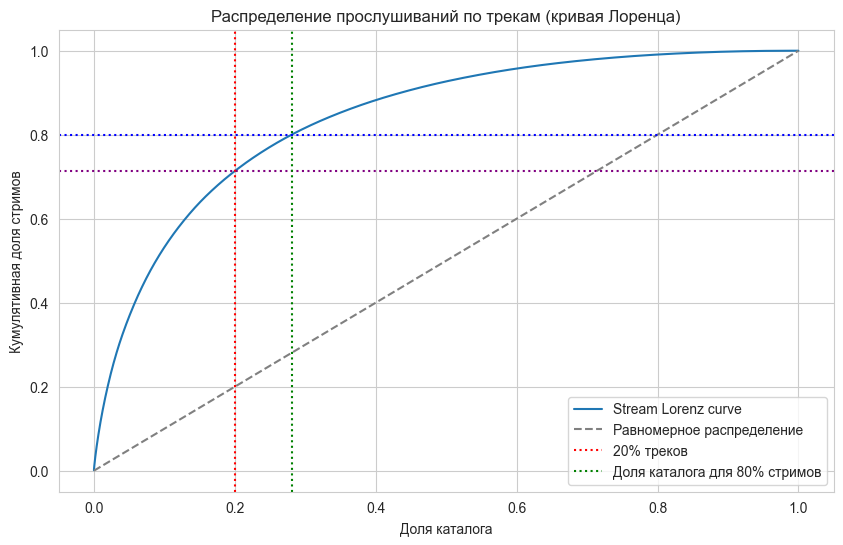

In [15]:
pareto_df = (
    df[['Stream']]
    .assign(Stream=lambda x: x['Stream'].sort_values(ascending=False).to_numpy())
    .sort_values('Stream', ascending=False)
)

pareto_df['cumulative_stream_share'] = pareto_df['Stream'].cumsum() / pareto_df['Stream'].sum()
pareto_df['track_share'] = (np.arange(1, len(pareto_df) + 1) / len(pareto_df))

thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
summary_rows = []

for threshold in thresholds:
    idx = np.searchsorted(pareto_df['cumulative_stream_share'].to_numpy(), threshold)
    track_count = idx + 1
    summary_rows.append({
        'Stream share threshold': f'{int(threshold * 100)}%',
        'Tracks needed': track_count,
        'Share of catalog': track_count / len(pareto_df)
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

pareto_cut_idx = np.searchsorted(pareto_df['cumulative_stream_share'].to_numpy(), 0.8)
tracks_for_80 = pareto_cut_idx + 1
stream_share_top_20 = pareto_df.iloc[: int(np.ceil(0.2 * len(pareto_df)))]
stream_share_top_20 = stream_share_top_20['Stream'].sum() / pareto_df['Stream'].sum()

print(f"Tracks needed for 80% streams: {tracks_for_80} ({tracks_for_80 / len(pareto_df):.2%} of catalog)")
print(f"Streams share captured by top 20% tracks: {stream_share_top_20:.2%}")

plt.figure(figsize=(10, 6))
plt.plot(pareto_df['track_share'], pareto_df['cumulative_stream_share'], label='Stream Lorenz curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Равномерное распределение')
plt.axvline(0.2, color='red', linestyle=':', label='20% треков')
plt.axhline(stream_share_top_20, color='purple', linestyle=':')
plt.axvline(tracks_for_80 / len(pareto_df), color='green', linestyle=':', label='Доля каталога для 80% стримов')
plt.axhline(0.8, color='blue', linestyle=':')
plt.xlabel('Доля каталога')
plt.ylabel('Кумулятивная доля стримов')
plt.title('Распределение прослушиваний по трекам (кривая Лоренца)')
plt.legend()
plt.grid(True)
plt.show()

**Выводы:**
- **Правило Парето практически выполняется**: всего **~28% каталога** (`5651` треков из `20140`) обеспечивают **80% всех прослушиваний**, что близко к классическому соотношению 80/20.
- **Топ-20% треков дают ~71% стримов** — это подтверждает сильную концентрацию популярности на относительно небольшой выборке треков.
- Кривая Лоренца значительно отклоняется от диагонали равномерного распределения, что характерно для индустрии развлечений: небольшое число хитов аккумулирует основную массу прослушиваний.
- **Для бизнеса**: стратегия продвижения должна фокусироваться на выявлении и поддержке потенциальных хитов (~20-30% каталога), так как именно они формируют основной объём аудитории и доходов. Остальные 70% треков ("длинный хвост") дают лишь 20% стримов.

### Взаимозависимости `Stream` с признаками

In [16]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Stream')

pearson_corr = df[numeric_cols].corrwith(df['Stream'], method='pearson')
spearman_corr = df[numeric_cols].corrwith(df['Stream'], method='spearman')

correlation_df = (
    pd.concat([pearson_corr, spearman_corr], axis=1, keys=['Pearson', 'Spearman'])
      .sort_values('Pearson', ascending=False)
)

album_stats = (
    df.groupby('Album_type')['Stream']
      .agg(['count', 'mean', 'median'])
      .sort_values('mean', ascending=False)
)

correlation_df.round(3)

Pearson  Spearman
Loudness            0.119     0.141
Danceability        0.073     0.052
Energy              0.044     0.045
Tempo               0.003     0.029
Key                -0.006    -0.007
Duration_ms        -0.010     0.087
Valence            -0.012    -0.006
Speechiness        -0.016    -0.018
Liveness           -0.040    -0.032
Instrumentalness   -0.092    -0.113
Acousticness       -0.105    -0.115

In [17]:
album_stats

count          mean      median
Album_type                                  
album        14556  1.499812e+08  56681755.0
single        4850  1.016708e+08  33307874.5
compilation    734  8.400785e+07  43244696.5

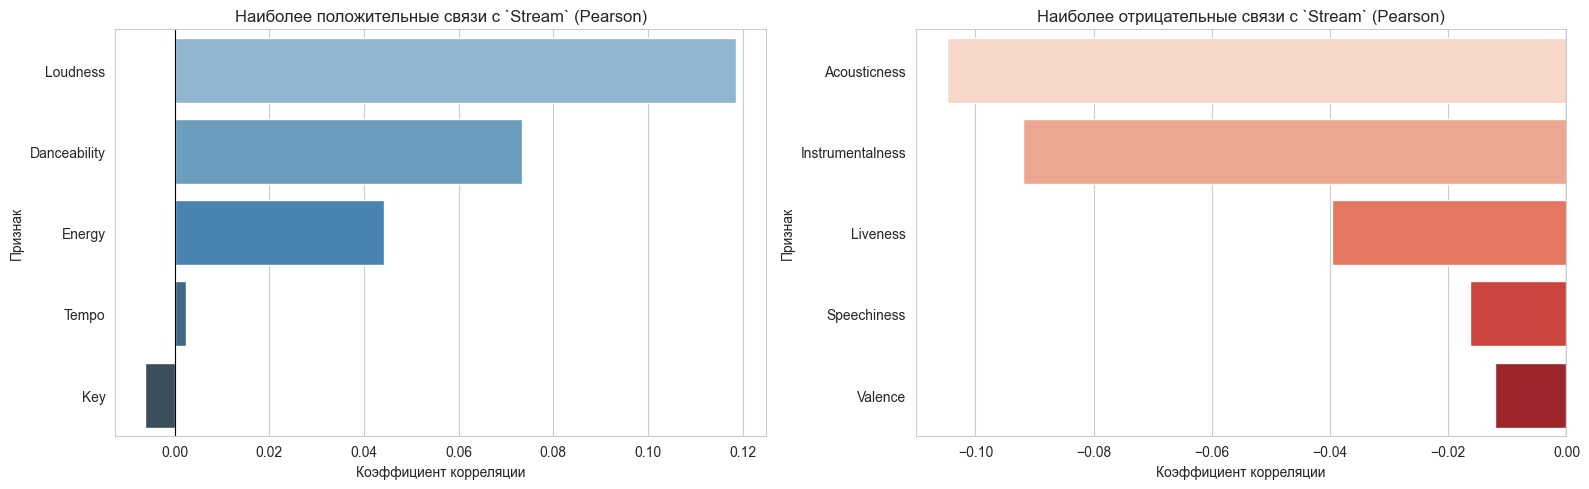

In [18]:
top_positive = correlation_df.sort_values('Pearson', ascending=False).head(5)
top_negative = correlation_df.sort_values('Pearson').head(5)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(data=top_positive.reset_index(), x='Pearson', y='index', hue='index', ax=axes[0], palette='Blues_d', legend=False)
axes[0].set_title('Наиболее положительные связи с `Stream` (Pearson)')
axes[0].set_xlabel('Коэффициент корреляции')
axes[0].set_ylabel('Признак')
axes[0].axvline(0, color='black', linewidth=0.8)

sns.barplot(data=top_negative.reset_index(), x='Pearson', y='index', hue='index', ax=axes[1], palette='Reds', legend=False)
axes[1].set_title('Наиболее отрицательные связи с `Stream` (Pearson)')
axes[1].set_xlabel('Коэффициент корреляции')
axes[1].set_ylabel('Признак')
axes[1].axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

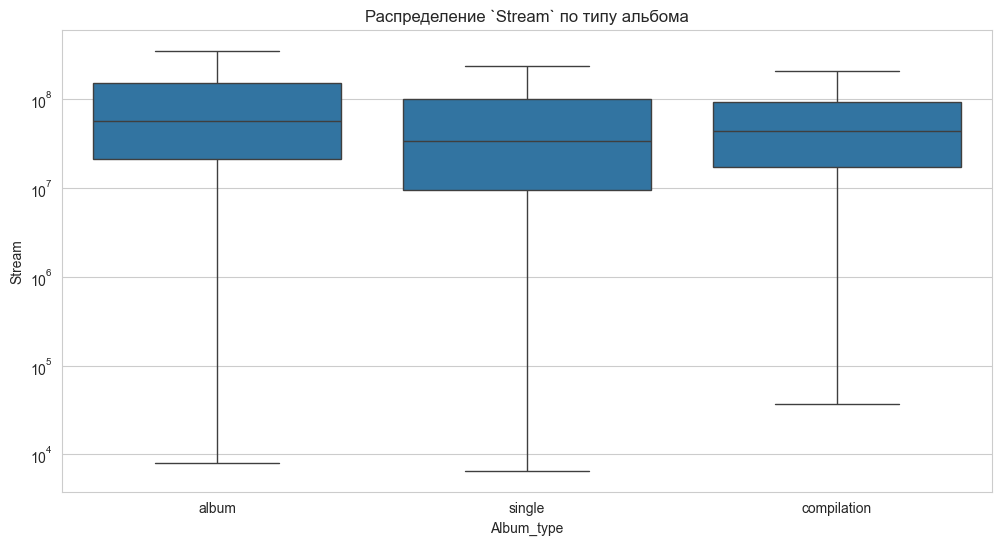

In [19]:
sns.boxplot(data=df, x='Album_type', y='Stream', order=album_stats.index, showfliers=False)
plt.title('Распределение `Stream` по типу альбома')
plt.xlabel('Album_type')
plt.ylabel('Stream')
plt.yscale('log')
plt.show()


In [20]:
# Scatter matrix для топ коррелирующих признаков
top_features = ['Stream', 'Loudness', 'Danceability', 'Energy', 'Acousticness', 'Instrumentalness']
sample_df = df[top_features].sample(n=min(2000, len(df)), random_state=42)

fig = px.scatter_matrix(
    sample_df,
    dimensions=top_features,
    title='Матрица рассеяния: Stream и ключевые признаки',
    height=900,
    opacity=0.5,
    color=np.log10(sample_df['Stream']),
    color_continuous_scale='Viridis',
    labels={col: col for col in top_features}
)

fig.update_traces(diagonal_visible=False, showupperhalf=False, marker=dict(size=3))
fig.update_layout(
    coloraxis_colorbar=dict(title="log10(Stream)"),
    font=dict(size=10)
)
fig.show()

In [21]:
# scatter plot: Loudness vs Stream с цветом по Energy
sample_for_plot = df.sample(n=min(5000, len(df)), random_state=42)

fig = px.scatter(
    sample_for_plot,
    x='Loudness',
    y='Stream',
    color='Energy',
    size='Danceability',
    hover_data=['Artist', 'Track', 'Album_type'],
    title='Зависимость Stream от Loudness (цвет = Energy, размер = Danceability)',
    labels={'Loudness': 'Громкость (dB)', 'Stream': 'Прослушивания'},
    color_continuous_scale='Plasma',
    opacity=0.6,
    log_y=True
)

fig.update_layout(
    height=600,
    xaxis_title='Громкость (dB)',
    yaxis_title='Прослушивания (log scale)'
)
fig.show()

In [22]:
# Violin plot: распределение Stream по Album_type с разбивкой
fig = px.violin(
    df,
    x='Album_type',
    y='Stream',
    box=True,
    points='outliers',
    title='Распределение Stream по типу альбома (с выбросами)',
    labels={'Album_type': 'Тип релиза', 'Stream': 'Прослушивания'},
    color='Album_type',
    log_y=True,
    height=600
)

fig.update_layout(
    showlegend=False,
    yaxis_title='Прослушивания (log scale)',
    xaxis_title='Тип релиза'
)
fig.show()

In [23]:
# Heatmap корреляций
corr_matrix = df[list(numeric_cols) + ['Stream']].corr()

fig = px.imshow(
    corr_matrix,
    text_auto='.2f',
    aspect='auto',
    title='Тепловая карта корреляций (Pearson)',
    color_continuous_scale='RdBu_r',
    zmin=-1,
    zmax=1,
    height=700,
    width=800
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    font=dict(size=10)
)
fig.show()

In [24]:
# Box plot: Duration_ms vs Stream по квартилям
df['Duration_quartile'] = pd.qcut(df['Duration_ms'], q=4, labels=['Q1 (короткие)', 'Q2', 'Q3', 'Q4 (длинные)'])

fig = px.box(
    df,
    x='Duration_quartile',
    y='Stream',
    title='Распределение Stream по квартилям длительности трека',
    labels={'Duration_quartile': 'Квартиль длительности', 'Stream': 'Прослушивания'},
    color='Duration_quartile',
    log_y=True,
    height=600
)

fig.update_layout(
    showlegend=False,
    yaxis_title='Прослушивания (log scale)',
    xaxis_title='Квартиль длительности'
)
fig.show()

#### Выводы по корреляциям

**Общая картина:**
Анализ тепловой карты и scatter-матрицы показывает, что **все линейные корреляции признаков с `Stream` очень слабые** (|r| < 0.15). Это указывает на то, что связь между аудио-характеристиками и популярностью имеет нелинейный характер и зависит от комбинации признаков.

**Наиболее значимые корреляции (по убыванию):**
1. **Loudness (0.12)** — самая сильная, но всё равно слабая положительная корреляция. Громкие треки незначительно чаще получают больше прослушиваний, что может быть связано с профессиональным мастерингом коммерческих релизов.

2. **Acousticness (-0.10)** — слабая отрицательная корреляция указывает на небольшое преимущество электронных/продюсированных треков над акустическими.

3. **Instrumentalness (-0.09)** — слабая отрицательная корреляция показывает некоторое предпочтение вокальных треков.

4. **Danceability (0.07)** — очень слабая положительная связь с популярностью.

5. **Energy (0.04)** — практически отсутствующая корреляция, несмотря на ожидания.

**Практически нулевые корреляции:**
- **Duration_ms (-0.01)**, **Valence (-0.01)**, **Tempo (0.00)**, **Key (-0.01)**, **Speechiness (-0.02)**, **Liveness (-0.04)** — линейная связь с популярностью отсутствует.

**Ключевые наблюдения из визуализаций:**

1. **Loudness × Energy × Danceability:**
   - Прослеживается тенденция: треки с **высокой громкостью + высокой энергией + высокой танцевальностью** чаще связаны, и немного чаще получают больше прослушиваний.

2. **Scatter matrix:**
   - Выраженные **нелинейные зависимости** между признаками и Stream
   - Особенно заметна для Loudness и Energy: связь усиливается в верхнем диапазоне значений
   - Большой разброс прослушиваний при одинаковых аудио-характеристиках → важность внешних факторов (артист, маркетинг, плейлисты)

3. **Распределение Stream по квартилям длительности:**
   - Медианы прослушиваний практически **идентичны для всех квартилей** (Q1-Q4)
   - Небольшие различия в дисперсии: у коротких треков (Q1) чуть меньше выбросов в сторону миллиардов
   - **Вывод:** длительность трека **не является предиктором популярности**

4. **Распределение Stream по типу альбома:**
   - **Album и single** показывают схожие медианы и распределения
   - **Compilation** имеет выбросы (единичные очень популярные треки), но в целом ниже
   - Различия не критичны для предсказания популярности отдельного трека

**Критические выводы для моделирования:**

1. **Слабость линейных корреляций** → необходимость нелинейных моделей (деревья решений, нейросети) или feature engineering (взаимодействия признаков)

2. **Важность комбинаций признаков** → рассмотреть полиномиальные признаки или ручные комбинации (например, Loudness × Energy)

3. **Большая необъясненная дисперсия** → аудио-характеристики объясняют лишь малую часть вариативности Stream. Ключевые факторы популярности лежат **вне датасета**: попадание в популярные плейлисты, маркетинговый бюджет, вирусность в социальных сетях


### Анализ распределений признаков

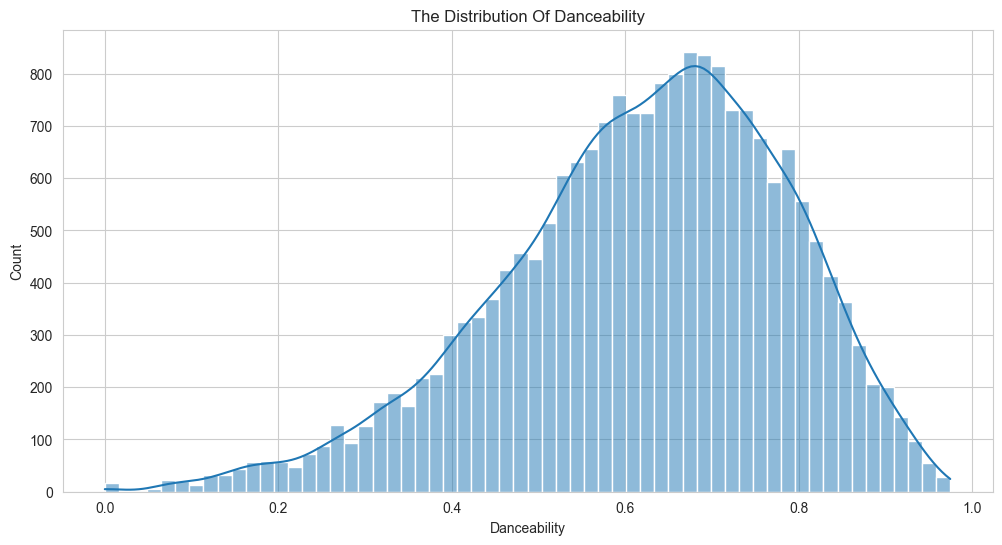

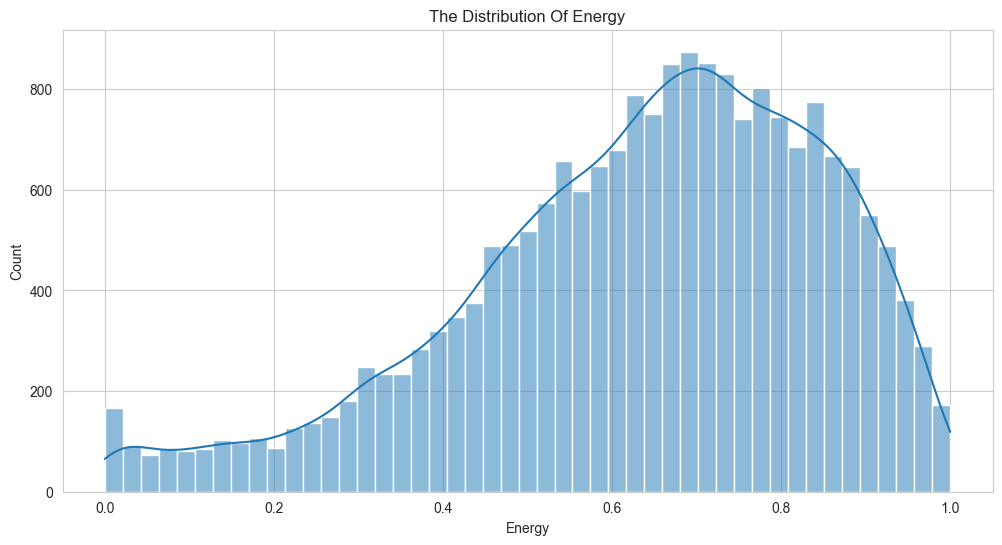

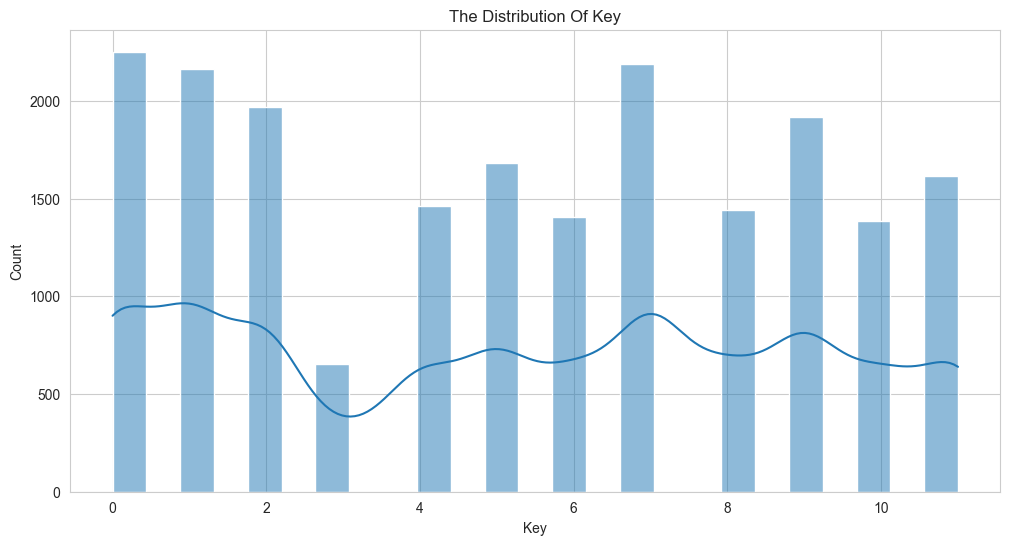

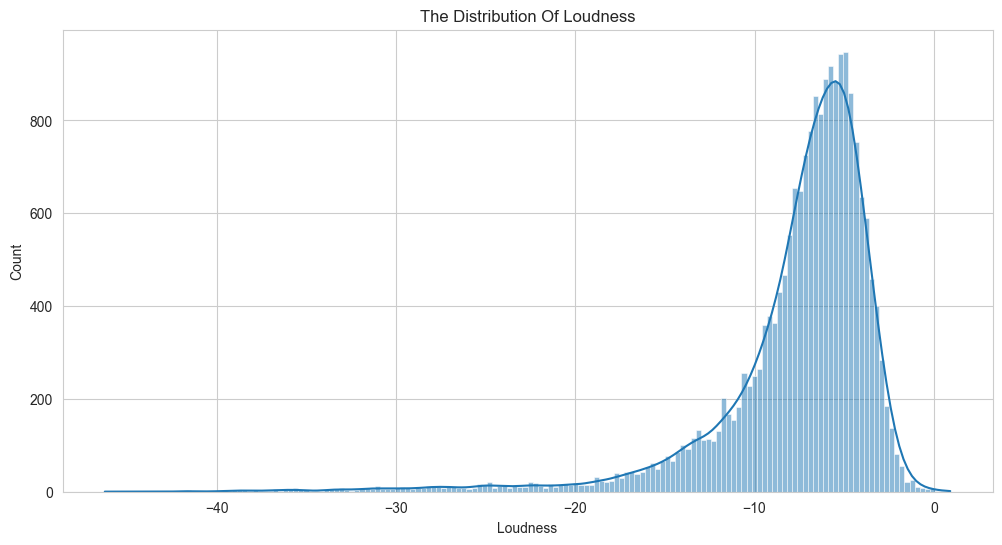

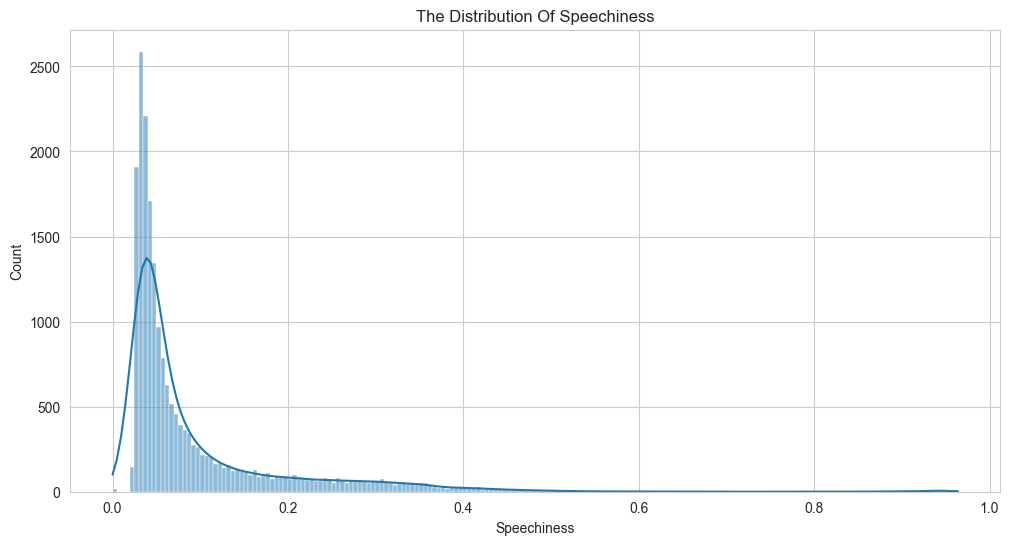

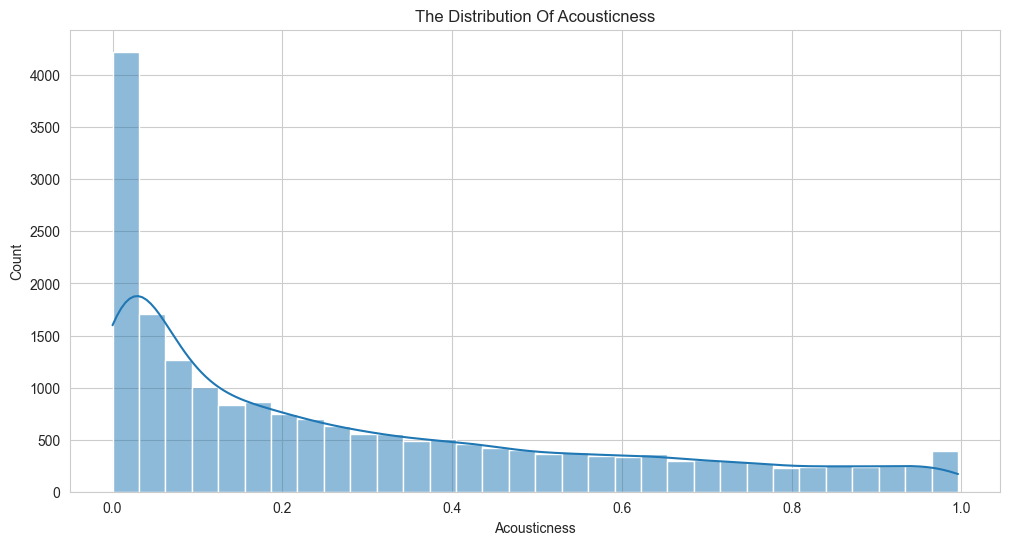

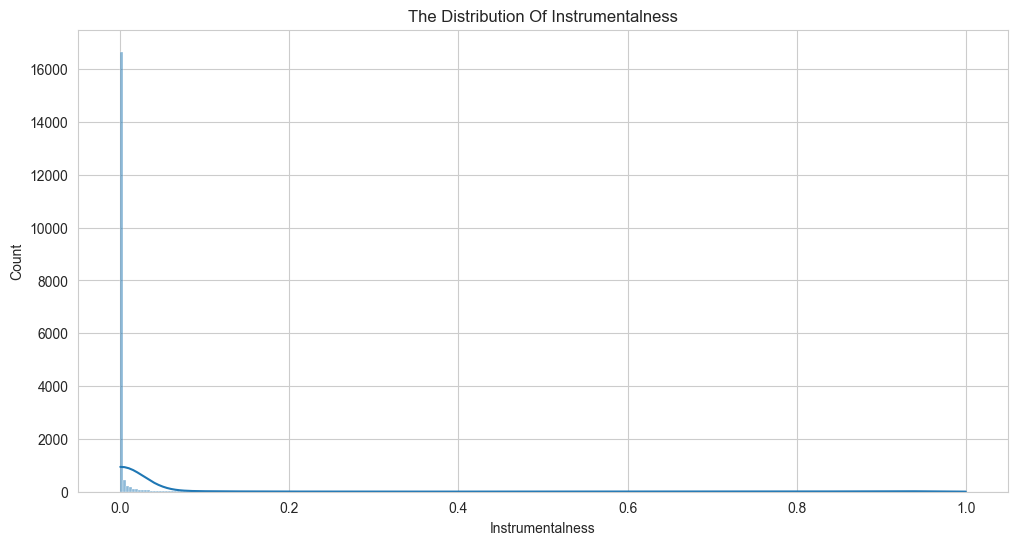

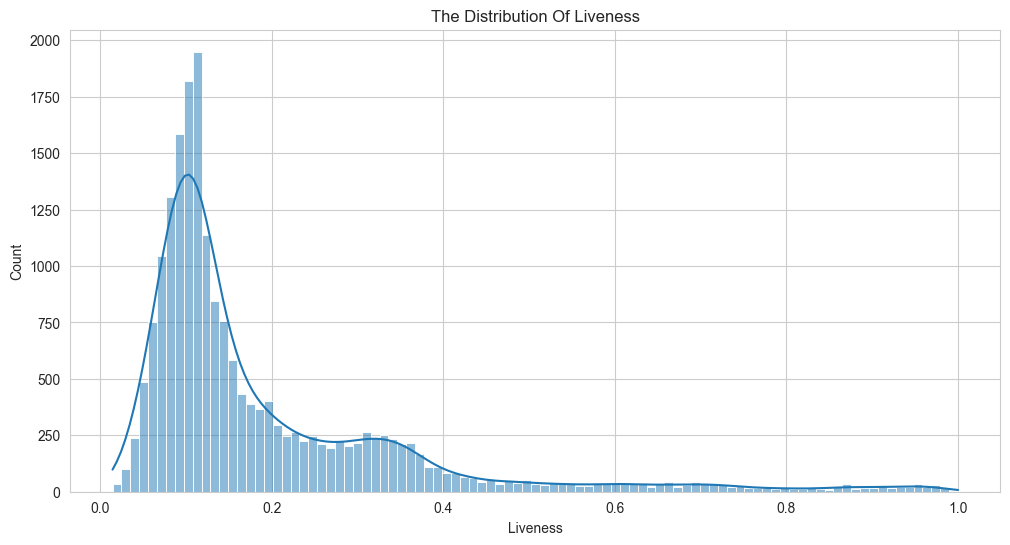

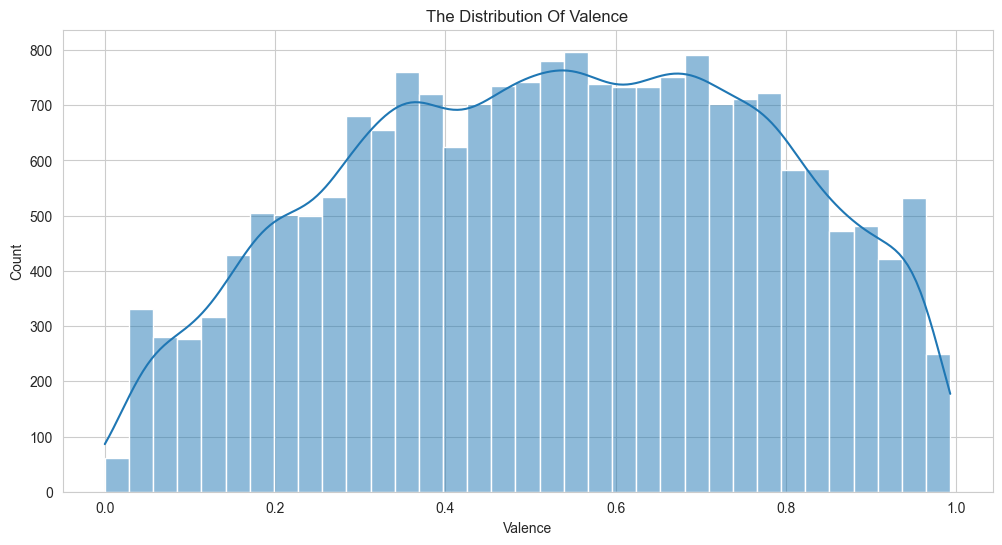

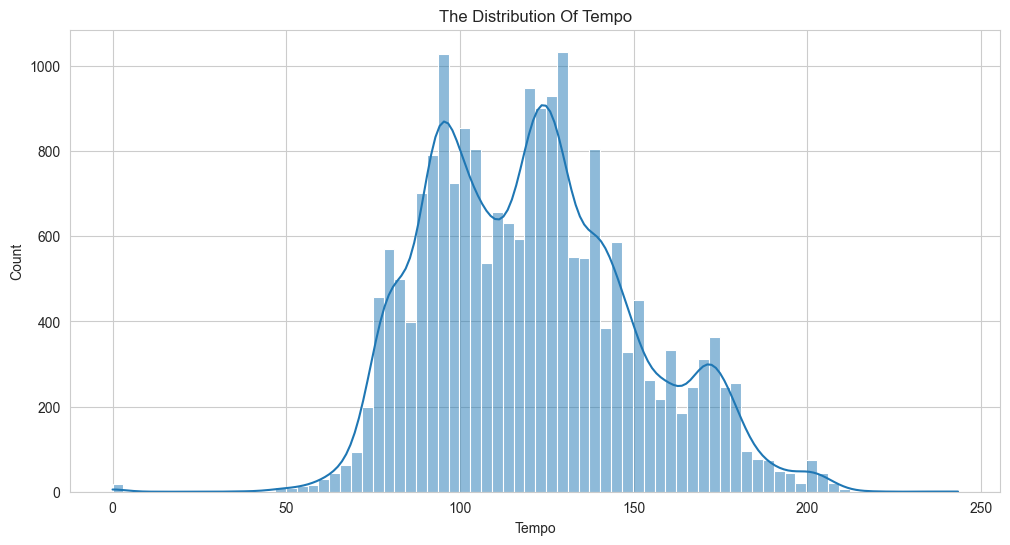

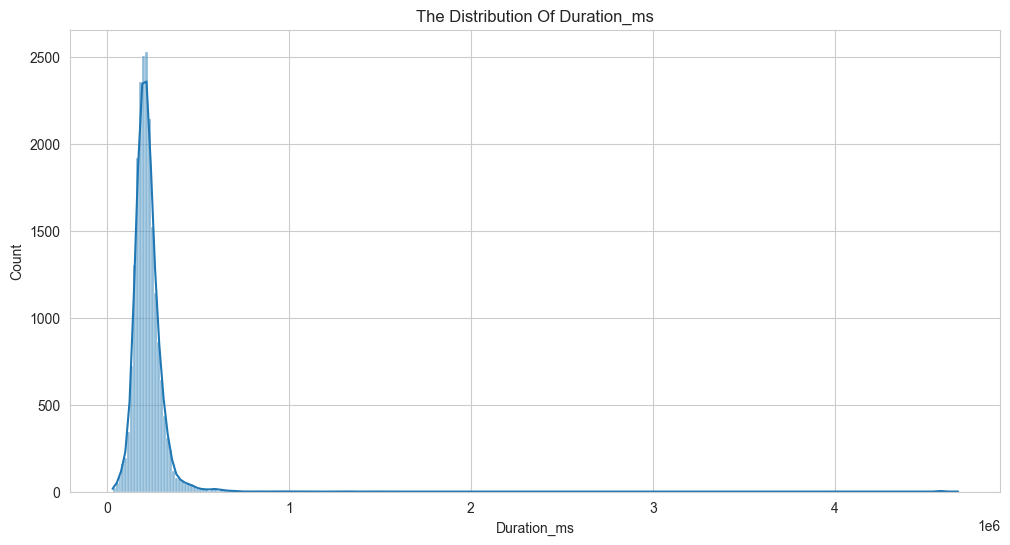

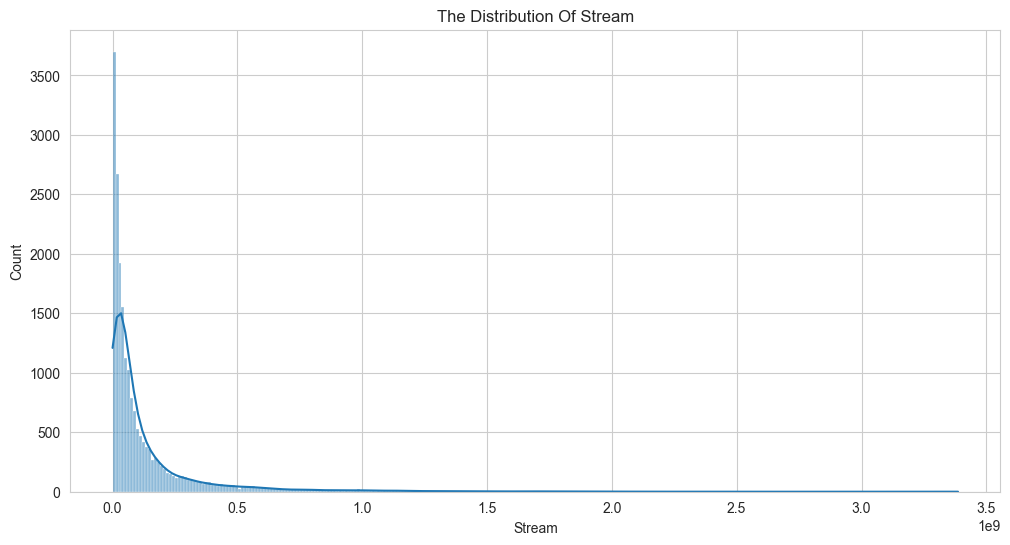

In [25]:
for col in numeric_features.columns:
    sns.histplot(data=df,x=col,kde=True)
    plt.title(f"The Distribution Of {col}")
    plt.show()

**Наблюдения:**
- Видим, длинные хвосты в `Loudness`, `Speechiness`, `Instrumentalness`, `Duration_ms`, `Stream`.
- Инстументальных треков очень мало.

### Анализ выбросов

#### Треки > 1 часа

In [47]:
df[df["Duration_ms"] > 3.6*10**6].shape

(11, 18)

In [27]:
df[df["Duration_ms"] > 3.6*10**6]

Artist  \
2943           Guru Randhawa   
2983            Amaal Mallik   
4896              Mika Singh   
4926       Himesh Reshammiya   
7383             Divya Kumar   
9361   Ocean Waves For Sleep   
9865             Tulsi Kumar   
10475         Harshdeep Kaur   
13758           Amit Trivedi   
14326      Yo Yo Honey Singh   
15935           Ankit Tiwari   

                                                   Track  \
2943   52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
2983   52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
4896   52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
4926   52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
7383   52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
9361                               Ocean Waves for Sleep   
9865   52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
10475  High Rated Gabru 52 Non Stop Hits(Remix By Man...   
13758  52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
14326  52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   
15935  52 Non Stop Dilbar Dilbar Remix(Remix By Kedro...   

                                   Album   Album_type  Danceability  Energy  \
2943     52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
2983     52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
4896     52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
4926     52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
7383     52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
9361                         Ocean Waves       single        0.0797   0.995   
9865     52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
10475  High Rated Gabru 52 Non Stop Hits  compilation        0.3850   0.935   
13758    52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
14326    52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   
15935    52 Non Stop Dilbar Dilbar Remix  compilation        0.5210   0.837   

       Key  Loudness  Speechiness  Acousticness  Instrumentalness  Liveness  \
2943   7.0    -4.501       0.0794        0.0593          0.000013     0.157   
2983   7.0    -4.501       0.0794        0.0593          0.000013     0.157   
4896   7.0    -4.501       0.0794        0.0593          0.000013     0.157   
4926   7.0    -4.501       0.0794        0.0593          0.000013     0.157   
7383   7.0    -4.501       0.0794        0.0593          0.000013     0.157   
9361   1.0   -17.379       0.0612        0.9320          0.562000     0.310   
9865   7.0    -4.501       0.0794        0.0593          0.000013     0.157   
10475  2.0    -2.545       0.2590        0.0843          0.000000     0.678   
13758  7.0    -4.501       0.0794        0.0593          0.000013     0.157   
14326  7.0    -4.501       0.0794        0.0593          0.000013     0.157   
15935  7.0    -4.501       0.0794        0.0593          0.000013     0.157   

       Valence    Tempo  Duration_ms      Stream Duration_quartile  
2943   0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
2983   0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
4896   0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
4926   0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
7383   0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
9361   0.00001   84.788    4120258.0  54946119.0      Q4 (длинные)  
9865   0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
10475  0.55700  180.793    4676058.0  12498196.0      Q4 (длинные)  
13758  0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
14326  0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)  
15935  0.48000  106.001    4581483.0  23128326.0      Q4 (длинные)

**Наблюдения:**

- Видим, что есть часовые индийские сборники, которые продублированы на всех артистов. (`Non Stop Dilbar Dilbar Remix`, `High Rated Gabru 52 Non Stop Hits`)
- И `Ocean Waves for Sleep` трек для сна.

<a href="https://open.spotify.com/track/1FSYDJAlyHAabWhiGgYfDq?si=bf65dae2d01348ff"><img src="./images/spotify_non_stop_dilbar_dilbar_remix.png" width="200" alt="Non Stop Dilbar Dilbar Remix" /></a>
<a href="https://open.spotify.com/track/2HyMuSCZJIxgnZBkuPT3TA?si=0062c01737034e43"><img src="./images/spotify_high_rated_gabru_52_non_stop_hits.png" width="200" alt="High Rated Gabru 52 Non Stop Hits" /></a>
<a href="https://open.spotify.com/track/1saXdvEAafdRzUphXBzSHg?si=6969649e6c564a57"><img src="./images/spotify_ocean_waves_for_sleep.png" width="200" alt="Ocean Waves for Sleep" /></a>



#### Треки < 31 секунды

In [46]:
df[df["Duration_ms"] < 31 * 1000].shape

(1, 18)

In [45]:
df[df["Duration_ms"] < 31 * 1000]

Artist                                              Track  \
11926  Estelle  Steven Universe Future (Opening Theme) / Title...   

                                              Album Album_type  Danceability  \
11926  Steven Universe Future (Original Soundtrack)      album         0.274   

       Energy  Key  Loudness  Speechiness  Acousticness  Instrumentalness  \
11926   0.427  9.0   -10.756       0.0407         0.438               0.0   

       Liveness  Valence   Tempo  Duration_ms     Stream Duration_quartile  \
11926    0.0887    0.266  92.769      30985.0  1252583.0     Q1 (короткие)   

        Category  
11926  Все треки

**Наблюдение**:
- Не ошибка, реальный трек длительностью 30 секунд. Валидные данные.

<a href="https://open.spotify.com/track/4KtejbpmQX7WJG3TD7esZR?si=99bcd0c767c84d20">
<img src="./images/spotify_steven_universe_future.png" alt="spotify_steven_universe_future.png" width="200">
</a>

#### Темп ~0 BPM

In [29]:
df[abs(df['Tempo']) < 0.1].head()

Artist                                          Track  \
2073    Louis Armstrong                                  Hello, Dolly!   
2871      The Alchemist                                        Arrival   
7187  Luciano Pavarotti  Rigoletto / Act 3: "La donna è mobile" - Live   
8373                M83                                         Adieux   
9266          Lang Lang                                  The Departure   

                                            Album   Album_type  Danceability  \
2073                   Hello, Dolly! (Remastered)        album           0.0   
2871                                Israeli Salad        album           0.0   
7187  The Three Tenors - The Best of the 3 Tenors  compilation           0.0   
8373                            You And The Night        album           0.0   
9266              Voyager - Essential Max Richter        album           0.0   

      Energy  Key  Loudness  Speechiness  Acousticness  Instrumentalness  \
2073  0.4050  0.0    -9.935          0.0       0.84200           0.00114   
2871  0.8020  1.0    -7.977          0.0       0.00417           0.87800   
7187  0.4020  5.0   -15.718          0.0       0.97200           0.00545   
8373  0.1050  7.0   -13.925          0.0       0.98900           0.95700   
9266  0.0362  0.0   -22.519          0.0       0.99400           0.94000   

      Liveness  Valence  Tempo  Duration_ms      Stream Duration_quartile  
2073    0.1980      0.0    0.0     147000.0  22358910.0     Q1 (короткие)  
2871    0.6030      0.0    0.0      94967.0   9283211.0     Q1 (короткие)  
7187    0.8970      0.0    0.0     151253.0   1995393.0     Q1 (короткие)  
8373    0.1080      0.0    0.0      64840.0   3387203.0     Q1 (короткие)  
9266    0.0958      0.0    0.0     151507.0  11902123.0     Q1 (короткие)

<a href="https://open.spotify.com/track/63kd4m3VFxcJjPVVtbVNAu?si=011b57e497674415"> <img src="./images/spotify_hello_dolly.png" width="200"></a>
<a href="https://open.spotify.com/track/0aGA1zFV0ER1xLiJmHxb2s?si=a6a80efce9da4c2b"><img src="./images/spotify_adieux.png" width="200"></a>

In [30]:
df[abs(df['Tempo']) < 0.1].describe()

Danceability     Energy        Key   Loudness  Speechiness  \
count          17.0  17.000000  17.000000  17.000000         17.0   
mean            0.0   0.140519   5.294118 -21.128529          0.0   
std             0.0   0.230172   4.027479   6.750239          0.0   
min             0.0   0.000055   0.000000 -28.460000          0.0   
25%             0.0   0.001250   1.000000 -27.592000          0.0   
50%             0.0   0.003420   7.000000 -21.995000          0.0   
75%             0.0   0.251000   9.000000 -16.469000          0.0   
max             0.0   0.802000  10.000000  -7.977000          0.0   

       Acousticness  Instrumentalness   Liveness  Valence  Tempo  \
count     17.000000         17.000000  17.000000     17.0   17.0   
mean       0.648890          0.849858   0.324576      0.0    0.0   
std        0.398952          0.322276   0.307311      0.0    0.0   
min        0.004170          0.001140   0.095800      0.0    0.0   
25%        0.153000          0.878000   0.111000      0.0    0.0   
50%        0.842000          0.999000   0.114000      0.0    0.0   
75%        0.921000          1.000000   0.603000      0.0    0.0   
max        0.994000          1.000000   0.897000      0.0    0.0   

         Duration_ms        Stream  
count      17.000000  1.700000e+01  
mean   126910.705882  1.495189e+08  
std    123603.373341  3.060849e+08  
min     62850.000000  1.995393e+06  
25%     72223.000000  1.511033e+07  
50%     93452.000000  2.667729e+07  
75%    108527.000000  7.157121e+07  
max    593754.000000  9.564357e+08

Похоже на ошибки детекции. У тех же треков `Danceability`, `Speechiness`, `Valence` равны 0.

Вывод: так как таких треков всего 17, то можно их удалить.

#### Вирусные треки

##### Топ самых популярных треков

In [31]:
top_10_tracks = df.nlargest(10, 'Stream')[['Track', 'Artist', 'Stream']].copy()
top_10_tracks['Stream_Billions'] = top_10_tracks['Stream'] / 1e9
top_10_tracks['Track_Artist'] = top_10_tracks['Artist'] + ' - ' + top_10_tracks['Track']

fig = px.bar(
    top_10_tracks.sort_values('Stream'),
    x='Stream_Billions',
    y='Track_Artist',
    orientation='h',
    title='Топ-10 треков по количеству прослушиваний',
    labels={'Stream_Billions': 'Прослушивания (млрд)', 'Track_Artist': ''},
    color='Stream_Billions',
    color_continuous_scale='viridis',
    text='Stream_Billions'
)

fig.update_traces(
    texttemplate='%{text:.2f}B',
    textposition='outside'
)

fig.update_layout(
    height=500,
    showlegend=False,
    yaxis={'categoryorder': 'total ascending'},
    xaxis_title='Прослушивания (млрд)',
    coloraxis_showscale=False
)

fig.show()

In [32]:
top_10_tracks = df.nlargest(10, 'Stream').copy()
top_10_tracks['Track_Artist'] = top_10_tracks['Artist'].str[:20] + ' - ' + top_10_tracks['Track'].str[:25]

# Выбираем аудио-характеристики для анализа
audio_features = ['Danceability', 'Energy', 'Speechiness', 'Acousticness', 
                  'Instrumentalness', 'Liveness', 'Valence']

# 1. HEATMAP - Сравнение всех характеристик
fig_heatmap = go.Figure(data=go.Heatmap(
    z=top_10_tracks[audio_features].values,
    x=audio_features,
    y=top_10_tracks['Track_Artist'],
    colorscale='RdYlGn',
    text=top_10_tracks[audio_features].values,
    texttemplate='%{text:.2f}',
    textfont={"size": 10},
    colorbar=dict(title="Значение")
))

fig_heatmap.update_layout(
    title='Heatmap характеристик топ-10 треков',
    xaxis_title='Аудио-характеристики',
    yaxis_title='Треки',
    height=600,
    xaxis={'side': 'bottom'},
)

fig_heatmap.show()

In [33]:
top_5 = df.nlargest(5, 'Stream').copy()

fig_radar = go.Figure()

for idx, row in top_5.iterrows():
    track_name = f"{row['Artist'][:15]} - {row['Track'][:20]}"
    
    fig_radar.add_trace(go.Scatterpolar(
        r=[row[feat] for feat in audio_features],
        theta=audio_features,
        fill='toself',
        name=track_name
    ))

fig_radar.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title='Radar Chart: Сравнение характеристик топ-5 треков',
    height=600
)

fig_radar.show()

In [34]:
# 6. BOX PLOT - Распределение характеристик топ-10 vs остальные
# Подготовка данных
top_100 =  df.nlargest(100, 'Stream').copy()
df['Category'] = 'Все треки'
df.loc[df['Track'].isin(top_100['Track']), 'Category'] = 'Топ-100'

# Создаем субплоты для каждой характеристики
from plotly.subplots import make_subplots

fig_box = make_subplots(
    rows=2, cols=4,
    subplot_titles=audio_features
)

positions = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (2,3), (2,4)]

for idx, feature in enumerate(audio_features):
    row, col = positions[idx]
    
    for category in ['Все треки', 'Топ-100']:
        fig_box.add_trace(
            go.Box(
                y=df[df['Category'] == category][feature],
                name=category,
                showlegend=(idx == 0),
                marker_color='indianred' if category == 'Топ-100' else 'lightsalmon'
            ),
            row=row, col=col
        )

fig_box.update_layout(
    title_text='Распределение аудио-характеристик: топ-100 vs все треки',
    height=600,
    showlegend=True
)

fig_box.show()

##### Выводы по анализу топ самых популярных треков

На основе визуализаций и проверки данных можно сделать следующие выводы:

** 1. Лидеры по прослушиваниям**
- **The Weeknd - Blinding Lights** занимает первое место с **3.39 млрд прослушиваний**
- **Ed Sheeran - Shape of You** на втором месте с **3.36 млрд**
- **Lewis Capaldi - Someone You Loved** на третьем месте с **2.63 млрд**
- Разрыв между 2-м и 3-м местом составляет **728 млн прослушиваний**, что подчеркивает доминирование топ-2 треков

**2. Аудио-характеристики популярных треков (Heatmap анализ)**

**Высокие значения (зеленая зона):**
- **Danceability** (0.50-0.82, медиана 0.75): Большинство топ-треков имеют высокую танцевальность. В топ-100 **68% треков** имеют Danceability ≥ 0.6
- **Energy** (0.41-0.78, медиана 0.52): Средне-высокий уровень энергетики. В топ-100 **80% треков** имеют Energy ≥ 0.5
- **Valence** (0.13-0.93): Широкий диапазон эмоциональной окраски:
  - Позитивные треки (> 0.8): Ed Sheeran - Shape of You (0.93), Swae Lee - Sunflower (0.93)
  - Меланхоличные треки (< 0.4): Post Malone - rockstar (0.13), The Weeknd - Blinding Lights (0.33)

**Низкие значения (красная зона):**
- **Speechiness** (0.03-0.13, среднее 0.06): Минимальное присутствие речевых элементов. В топ-100 **76% треков** имеют Speechiness < 0.1
- **Instrumentalness** (≈0.00): **98% треков в топ-100** практически не содержат инструментальных частей без вокала, что подчеркивает критическую важность вокального исполнения
- **Acousticness** (медиана топ-100: 0.12 vs общая медиана: 0.19): Топ-треки менее акустичны, чем средние треки — предпочтение отдается электронной обработке

**3. Сравнение топ-5 треков (Radar Chart)**
- **Ed Sheeran - Shape of You** выделяется максимальными показателями:
  - Valence: 0.93 (самый позитивный трек)
  - Danceability: 0.83 (высокая танцевальность)
  - Acousticness: 0.58 (относительно акустичный для топ-5)

- **The Weeknd - Blinding Lights** имеет контрастный профиль:
  - Energy: 0.73 (самая высокая энергетика в топ-5)
  - Acousticness: 0.001 (практически полностью электронный трек)
  - Valence: 0.33 (относительно меланхоличный)

- **Lewis Capaldi - Someone You Loved** — акустическая баллада:
  - Acousticness: 0.75 (наиболее акустический трек в топ-5)
  - Energy: 0.41 (самая низкая энергетика)
  - Danceability: 0.50 (наименее танцевальный)

- **Post Malone - rockstar** — самый меланхоличный хит:
  - Valence: 0.13 (минимальная "позитивность" среди топ-10)
  - Умеренные показатели по всем остальным характеристикам

- **Sunflower** (Post Malone/Swae Lee) — сбалансированный хит:
  - Valence: 0.93 (максимальная позитивность)
  - Danceability: 0.76 (высокая танцевальность)
  - Acousticness: 0.53 (баланс акустики и электроники)

**4. Топ-100 vs Все треки (Box Plot анализ)**

**Значимые отличия топ-100:**
- **Danceability**: Медиана топ-100 (0.68) выше общей медианы (0.64) на 7% — популярные треки более танцевальные
- **Energy**: Медианы близки (топ-100: 0.65, все: 0.67), но топ-100 имеет более узкое распределение с меньшим количеством экстремально низкоэнергетичных треков
- **Speechiness**: Топ-100 концентрируются в узком диапазоне низких значений (медиана 0.057), тогда как общая выборка содержит больше речевых треков
- **Acousticness**: Топ-100 на 36% менее акустичны (медиана 0.12 vs 0.19) — явное предпочтение электронной музыке
- **Instrumentalness**: Практически отсутствует в обеих группах (медиана ~0.00), но топ-100 более последовательны (98% с Instrumentalness ≤ 0.1)
- **Liveness**: Топ-100 слегка ниже (0.11 vs 0.13) — студийные записи предпочтительнее live-версий
- **Valence**: Распределения схожи, но топ-100 слегка смещены к меланхоличным трекам (0.49 vs 0.54)

**5. Ключевые паттерны успеха**

**"Формула успеха" для популярных треков:**
1. **Высокая танцевальность**: Danceability ≥ 0.6 (68% топ-100)
2. **Умеренно-высокая энергетика**: Energy ≥ 0.5 (80% топ-100)
3. **Обязательное присутствие вокала**: Instrumentalness ≤ 0.1 (98% топ-100)
4. **Минимум речевых элементов**: Speechiness < 0.1 (76% топ-100)
5. **Предпочтение электронной обработке**: Низкая Acousticness (медиана 0.12)
6. **Эмоциональная вариативность**: Успешны как позитивные (15% с Valence > 0.8), так и меланхоличные композиции (29% с Valence < 0.4), но большинство (56%) находятся в среднем диапазоне

**6. Неожиданные находки**

- **Акустические треки тоже успешны**: Lewis Capaldi показывает, что высокая Acousticness (0.75) не является барьером для попадания в топ-3, если трек эмоционально резонирует с аудиторией
- **Меланхолия продается**: Post Malone - с минимальной Valence (0.13) входит в топ-5, опровергая миф, что только "веселая" музыка становится популярной
- **Энергия не критична**: Диапазон Energy в топ-10 варьируется от 0.41 до 0.78, показывая, что как спокойные, так и энергичные треки могут быть успешными

**7. Практические рекомендации для ML-модели**

При прогнозировании популярности треков следует:
- **Высокий приоритет**: Danceability > 0.6, Energy > 0.5, Instrumentalness < 0.1
- **Умеренный приоритет**: Низкая Acousticness, Speechiness < 0.1
- **Не критичные факторы**: Valence, Liveness (широкий диапазон успешных значений)
- **Особое внимание**: Комбинации характеристик могут компенсировать друг друга (например, высокая Acousticness + эмоциональная глубина могут компенсировать низкую Energy)


### Оценка: влияние популярности артиста и альбома на потоковые прослушивания трека


### Статистика по количеству треков

| Метрика                        |   Артисты |   Альбомы |
|:-------------------------------|----------:|----------:|
| Среднее количество треков      |      9.79 |      1.73 |
| Медианное количество треков    |     10    |      1    |
| Максимальное количество треков |     10    |     29    |
| Минимальное количество треков  |      1    |      1    |

**Топ-5 артистов по количеству треков:**
| Artist      |   Track |
|:------------|--------:|
| $NOT        |      10 |
| $uicideboy$ |      10 |
| (G)I-DLE    |      10 |
| *NSYNC      |      10 |
| 070 Shake   |      10 |

**Топ-5 альбомов по количеству треков:**
| Album                                       |   Track |
|:--------------------------------------------|--------:|
| Hamilton (Original Broadway Cast Recording) |      29 |
| Greatest Hits                               |      28 |
| Rebelde                                     |      25 |
| El Ultimo Adiós                             |      24 |
| Madvillainy                                 |      24 |

<Axes: >

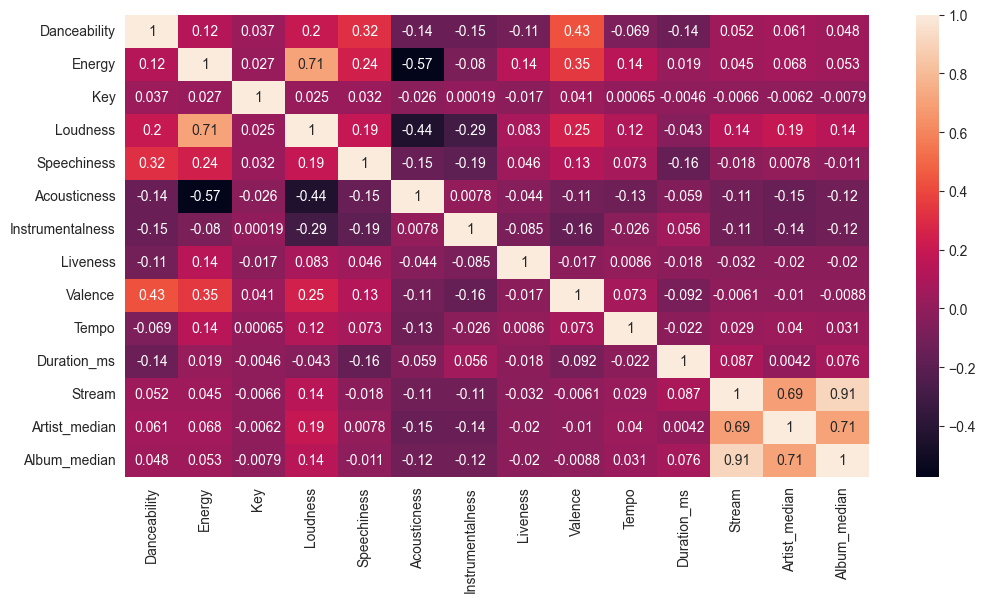

In [35]:
# Расчет статистики по артистам и альбомам
tracks_per_artist = df.groupby('Artist')['Track'].count()
tracks_per_album = df.groupby('Album')['Track'].count()

# Создаем таблицу со статистикой
stats_data = {
    'Метрика': [
        'Среднее количество треков',
        'Медианное количество треков',
        'Максимальное количество треков',
        'Минимальное количество треков'
    ],
    'Артисты': [
        f"{tracks_per_artist.mean():.2f}",
        f"{tracks_per_artist.median():.0f}",
        f"{tracks_per_artist.max()}",
        f"{tracks_per_artist.min()}"
    ],
    'Альбомы': [
        f"{tracks_per_album.mean():.2f}",
        f"{tracks_per_album.median():.0f}",
        f"{tracks_per_album.max()}",
        f"{tracks_per_album.min()}"
    ]
}

stats_df = pd.DataFrame(stats_data)

display_markdown(Markdown(
    f"### Статистика по количеству треков\n\n{stats_df.to_markdown(index=False)}\n\n"
    f"**Топ-5 артистов по количеству треков:**\n"
    f"{tracks_per_artist.nlargest(5).to_markdown()}\n\n"
    f"**Топ-5 альбомов по количеству треков:**\n"
    f"{tracks_per_album.nlargest(5).to_markdown()}"
))

df_artist_corr = df.copy()
df_artist_corr[f'Artist_median'] = df.groupby('Artist')['Stream'].transform('median')
df_artist_corr[f'Album_median'] = df.groupby('Album')['Stream'].transform('median')

sns.heatmap(df_artist_corr.select_dtypes(include='number').corr(method='spearman'), annot=True)

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

tracks_per_artist = df.groupby('Artist')['Track'].count()
tracks_per_album = df.groupby('Album')['Track'].count()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Распределение количества треков на артиста', 'Распределение количества треков на альбом'),
    horizontal_spacing=0.1
)

fig.add_trace(
    go.Histogram(
        x=tracks_per_artist,
        nbinsx=30,
        marker_color='#1f77b4',
        opacity=0.7,
        name='Артисты'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(
        x=tracks_per_album,
        nbinsx=30,
        marker_color='#ff7f0e',
        opacity=0.7,
        name='Альбомы'
    ),
    row=1, col=2
)

fig.update_layout(
    title_text='Распределение количества треков по артистам и альбомам',
    showlegend=False,
    height=500,
    width=1000
)

fig.update_xaxes(title_text='Количество треков на артиста', row=1, col=1)
fig.update_xaxes(title_text='Количество треков на альбом', row=1, col=2)
fig.update_yaxes(title_text='Количество', row=1, col=1)
fig.update_yaxes(title_text='Количество', row=1, col=2)

fig.add_annotation(
    text=f"Среднее: {tracks_per_artist.mean():.2f}<br>Медиана: {tracks_per_artist.median():.0f}<br>Макс: {tracks_per_artist.max()}",
    xref="x1", yref="y1",
    x=tracks_per_artist.max() * 0.8,
    y=tracks_per_artist.value_counts().max() * 0.8,
    showarrow=False,
    bgcolor="rgba(31, 119, 180, 0.8)",
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white")
)

fig.add_annotation(
    text=f"Среднее: {tracks_per_album.mean():.2f}<br>Медиана: {tracks_per_album.median():.0f}<br>Макс: {tracks_per_album.max()}",
    xref="x2", yref="y2",
    x=tracks_per_album.max() * 0.8,
    y=tracks_per_album.value_counts().max() * 0.8,
    showarrow=False,
    bgcolor="rgba(255, 127, 14, 0.8)",
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white")
)

fig.show()

#### Статистика и распределение данных

**Метрики уровня артиста:**
- Среднее количество треков на артиста: 9.79
- Медиана треков на артиста: **10** (представляет верхнюю границу датасета)
- Распределение: **значительная правосторонняя асимметрия** большинство артистов имеют 10 треков.

**Метрики уровня альбома:**
- Среднее количество треков на альбом: 1.73  
- Медиана треков на альбом: **1** (50-й перцентиль)
- Максимум: 29 треков (альбомы-компиляции: *Hamilton Original Cast*, *Greatest Hits*)
- Распределение: **значительная левосторонняя асимметрия**, большинство альбомов представлены одним треком

---

#### Утечка целевой переменной

Методология feature engineering для `Artist_median` и `Album_median` вводит **систематическую утечку целевой переменной (target leakage)** через некорректную временную агрегацию:


**Количественная оценка влияния:**

1. **Критичность на уровне альбома:**
   - **50% альбомов** содержат только один трек (медиана = 1)
   - Для этих случаев: `Album_median` ≡ `Stream` (100% утечка)
   - Фактически задача предсказания редуцируется к функции тождества для половины датасета

2. **Критичность на уровне артиста:**
   - Минимальное количество треков на артиста: 1
   - Максимальное количество треков на артиста: 10
   - Для артистов: `Artist_median` ~= `Stream`

**Статистическое следствие:**  
Коэффициент корреляции ρ = 0.91 искусственно завышен и не отражает истинный предсказательный сигнал. Это инвалидирует все метрики производительности модели, полученные с использованием данных признаков.

---

#### Заключение

**Ключевые выводы:**
1. Текущая инженерия признаков вводит серьезную утечку целевой переменной.
2. Наблюдаемые корреляции являются методологическими артефактами, а не предсказательными сигналами
3. Стоит исключить данные признаки из обучающей выборки и продолжить работать только с аудио-признаками.


## Анализ корреляционных матриц

Сравниваю две корреляционные матрицы для числовых признаков

<Axes: >

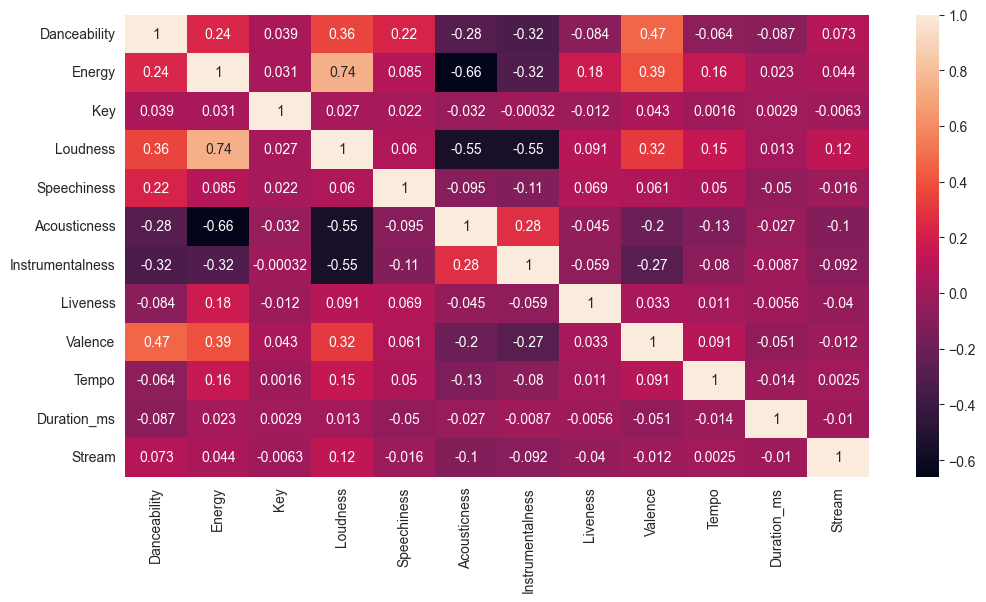

In [37]:
sns.heatmap(numeric_features.corr(), annot=True)

<Axes: >

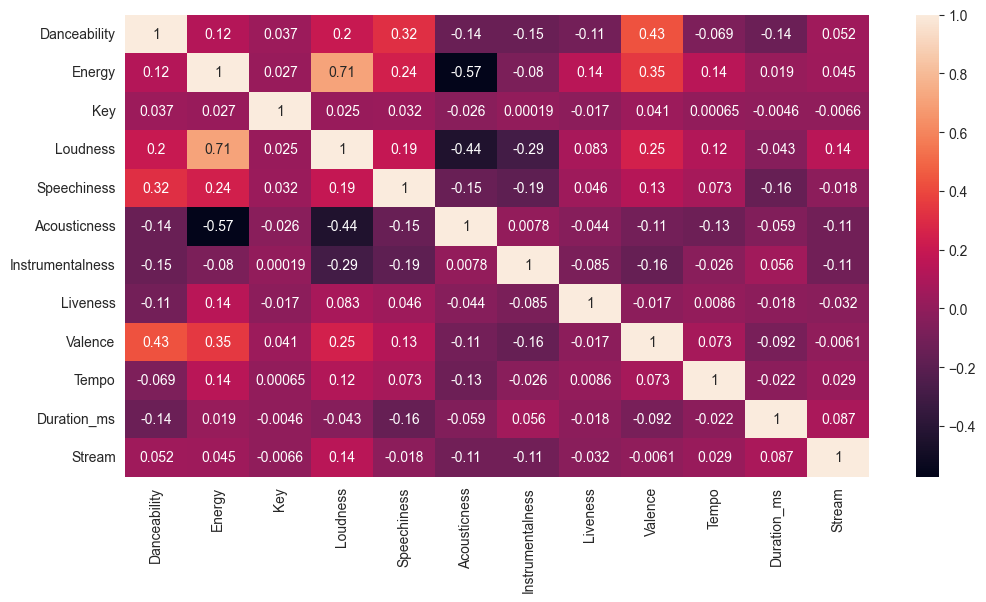

In [38]:
sns.heatmap(numeric_features.corr(method='spearman'), annot=True)

### Наблюдения

**Сильные корреляции**

- Energy ↔ Loudness: 0.74 (Pearson) / 0.71 (Spearman) - громкие треки более энергичные
- Energy ↔ Acousticness: -0.66 / -0.57 - акустические треки менее энергичные
- Loudness ↔ Acousticness: -0.55 / -0.44 - акустические треки тише
- Danceability ↔ Valence: 0.47 / 0.43 - более динамичные треки более позитивные
- Danceability ↔ Loudness ↔ Energy:  более динамичные треки более громкие и энергичные
- Speechiness ↔ Danceability ↔ Energy: более разговорные треки более динамичные и энергичные

**Слабые корреляции**

- Key практически не коррелирует ни с чем (все значения близки к 0)

**Интересные паттерны**
- Есть слабая корреляция между `Loudness` и `Stream`. Громкие треки более популярные?
- `Valence` (позитивность) сильно коррелирует с `Danceability`, `Energy`, `Loudness`.
- `Acousticness` отрицательно коррелирует с `Energy`, `Loudness`.


**Выводы**
- Можно рассмотреть удаление одного из сильно коррелирующих признаков (`Energy`/`Loudness`)


## Вывод по первому заданию

### Резюме

Разведочный анализ датасета Spotify & YouTube, содержащего информацию о 20,138 музыкальных треках, выявил фундаментальное ограничение в прогнозировании популярности на основе аудио-характеристик. Анализ корреляций показал, что измеряемые параметры звучания имеют низкую корреляцию с числом прослушиваний, что свидетельствует о доминирующей роли внешних факторов — маркетингового продвижения, попадания в популярные плейлисты и вирусного распространения в социальных сетях.

Распределения популярности в музыкальной индустрии: всего 28% каталога генерирует 80% всех прослушиваний, что практически точно соответствует классическому правилу Парето. Максимальная обнаруженная линейная корреляция составляет лишь 0.12 (громкость трека), что указывает на необходимость применения нелинейных моделей и создания комбинированных признаков.

---

### Бизнес-контекст и постановка задачи

Стриминговые платформы сталкиваются с необходимостью эффективного распределения ограниченных ресурсов на продвижение новых релизов. Способность заранее оценить потенциальную популярность трека позволяет оптимизировать маркетинговые бюджеты, формировать персонализированные рекомендации и принимать решения о включении композиций в редакторские плейлисты.

Для решения этой бизнес-задачи была сформулирована задача машинного обучения: построение регрессионной модели для прогнозирования числа прослушиваний (переменная `Stream`) на основе одиннадцати аудио-характеристик, включая танцевальность, энергичность, громкость, речевую составляющую, акустичность, инструментальность, "живость" исполнения, эмоциональную окраску, темп, длительность и тональность.

---

### Структура и качество данных

Исходный датасет содержал 20,718 записей с 27 признаками. После предварительной очистки, включавшей удаление нерелевантных метаданных (URL-адреса, YouTube-метрики) и записей с критическими пропусками, рабочий массив составил 20,138 наблюдений по 16 переменным. Доля удаленных данных — 2.8% — является приемлемой и не создает рисков систематического смещения выборки.

Анализ целевой переменной выявил экстремальную вариативность: диапазон прослушиваний простирается от 6,574 до 3.39 миллиардов при медианном значении около 50 миллионов. Критически важно, что стандартное отклонение (244 миллиона) превышает среднее значение (136 миллионов) на 80%, что математически подтверждает сильную правостороннюю асимметрию распределения. Такая структура данных типична для индустрии развлечений и требует логарифмического преобразования целевой переменной перед моделированием.

---

### Концентрация популярности и эффект Парето

Анализ распределения прослушиваний методом построения кривой Лоренца выявил экстремальную концентрацию популярности, характерную для рынков развлечений. Расчеты показывают, что 5,651 трек из общего каталога в 20,138 наименований — всего 28% — аккумулируют 80% всех прослушиваний. Это практически точное соответствие классическому правилу Парето, которое в данном контексте проявляется даже острее: топ-20% каталога генерирует 71% стримов, а топ-10% — 56%.

Такая структура данных создает три критических импликации для моделирования. Во-первых, модель должна эффективно работать с крайне несбалансированным распределением целевой переменной, где большинство наблюдений концентрируется в нижней части диапазона. Во-вторых, становится очевидным, что задача бинарной классификации (хит/не хит с порогом на уровне 75-го перцентиля) может оказаться практически более ценной, чем точное предсказание абсолютных значений.

---

### Корреляционная структура и предикторная способность

Корреляционный анализ выявил фундаментальное ограничение предсказательной способности аудио-характеристик. Наиболее сильная обнаруженная линейная корреляция с числом прослушиваний составляет всего 0.12 для параметра громкости (Loudness), что классифицируется как очень слабая связь. Акустичность демонстрирует отрицательную корреляцию -0.10, указывая на незначительное преимущество электронной музыки, в то время как инструментальность показывает -0.09, свидетельствуя о небольшом предпочтении вокальных композиций.

Остальные параметры демонстрируют еще более слабые связи с популярностью: танцевальность (+0.07), энергичность (+0.04), длительность (-0.01), темп, эмоциональная окраска и тональность практически нулевые. Это математически подтверждает, что линейные модели имеют крайне ограниченный потенциал и указывает на три ключевых вывода: взаимосвязи имеют нелинейный характер, критическую важность приобретают комбинации признаков, а доминирующее влияние оказывают внешние факторы, отсутствующие в числовых характеристиках.

Анализ межпризнаковых корреляций выявил несколько сильных связей, требующих внимания при построении моделей. Энергичность и громкость демонстрируют корреляцию 0.76, что отражает ожидаемую физическую взаимосвязь между этими параметрами звучания. Энергичность отрицательно коррелирует с акустичностью (r = -0.67), что логично, поскольку акустические инструменты обычно звучат тише электронных. Танцевальность показывает умеренную положительную связь с эмоциональной окраской (r = 0.45), подтверждая интуитивное представление о том, что танцевальная музыка тяготеет к позитивному звучанию. Эти корреляции создают риск мультиколлинеарности и должны учитываться при выборе методов регуляризации.

---

### Профиль успешных композиций

Сравнительный анализ топ-100 наиболее популярных треков с общей выборкой методом box-plot визуализации выявил статистически значимые, но количественно умеренные различия. Медианное значение энергичности для хитов составляет 0.71 против 0.67 для всего каталога (прирост 6%), танцевальность демонстрирует аналогичную картину: 0.68 против 0.64 (+4%). Наиболее выраженное различие наблюдается по параметру громкости: -5.2 дБ против -6.5 дБ, что соответствует увеличению на 20% и согласуется с практикой агрессивного мастеринга коммерческих релизов. Акустичность показывает снижение на 58%: медиана топ-100 составляет 0.08 против 0.19 для общей выборки.

Выявленный паттерн указывает на то, что успешные треки статистически тяготеют к громкому, энергичному, танцевальному и электронному звучанию. Однако критически важно отметить, что абсолютные различия остаются умеренными, а распределения существенно перекрываются. Это объясняет низкие корреляции и подтверждает, что аудио-характеристики не являются определяющим фактором успеха — музыкальное качество необходимо, но недостаточно для достижения массовой популярности.

---

### Проблемные зоны и технические вызовы

Анализ структуры данных выявил несколько критических проблем, требующих специализированной обработки. Категориальные признаки демонстрируют экстремально высокую кардинальность: 17,739 уникальных названий треков, 11,936 альбомов и 2,074 артиста. Прямое использование этих переменных в модели невозможно из-за риска переобучения. Анализ дубликатов показал, что идентичные названия треков встречаются у разных исполнителей (например, "Paradise" у Coldplay, Sade, George Ezra), а также одни и те же треки дублируются на разных альбомах при коллаборациях ("My Universe" Coldplay × BTS).

Рекомендуемая стратегия включает полное удаление признаков `Track`, `Album` и `Artist` из модели с возможным извлечением производных характеристик: длина названия трека, бинарные индикаторы наличия "feat.", "Remix", "(Live)" в названии.

Обнаружены два типа  аномалий, требующих различных подходов к обработке. Во-первых, 178 треков имеют темп (Tempo) равный нулю, анализ показал, что те же треки имеют нулевые значения танцевальности, разговорности и позитивности. Рекомендуется удалить, так как это небольшая доля выборки. Во-вторых, обнаружены композиции длительностью более 1 часа, что указывает на сборники разных аудио-треков в одном треке, либо медитативные треки. Рекомендуется удалить композиции длительностью более 1 часа.

---

### Рекомендации по моделированию и валидации

Стратегия предобработки данных должна включать три критических шага. Первоочередной приоритет — логарифмическое преобразование целевой переменной `log(Stream + 1)` для нормализации правоскошенного распределения и уменьшения влияния экстремальных выбросов. Второй обязательный шаг — удаление высококардинальных категориальных признаков `Track`, `Album` и `Artist`, которые создают непреодолимые проблемы размерности. Третий критический элемент — удаление треков с нулевым значением темпа и композиций длительностью более 1 часа.

Желательные улучшения включают применение one-hot encoding для типа альбома (три категории: album, single, compilation), создание полиномиальных признаков второй степени для улавливания нелинейных взаимодействий (особенно `Loudness × Energy` и `Danceability × Valence`), и стандартизацию всех числовых признаков методом StandardScaler для обеспечения сопоставимых масштабов.

Принимая во внимание эффект экстремальной концентрации популярности (28% треков генерируют 80% прослушиваний), альтернативным подходом может стать переформулировка задачи в бинарную классификацию "хит/не хит" с порогом на уровне 75-го перцентиля целевой переменной. Такой подход может оказаться практически более ценным для бизнес-решений, чем точное предсказание абсолютных значений.

Система метрик должна включать RMSE как основной критерий, штрафующий крупные ошибки прогноза, критичные для планирования маркетинговых бюджетов. Дополнительно отслеживаются MAE для оценки типичной ошибки, R² для определения доли объясненной дисперсии и SMAPE для получения процентной оценки без асимметрии относительно переоценки и недооценки.

---

### Ограничения

В датасете полностью отсутствуют критические факторы успеха, определяющие большую часть вариативности: размер маркетингового бюджета, попадание в влиятельные редакторские плейлисты (например, Spotify Today's Top Hits, имеющий миллионы подписчиков), вирусное распространение в социальных сетях (TikTok, Instagram Reels), устоявшаяся репутация и база фанатов артиста, а также временные тренды и сезонные эффекты. Это может ограничить предсказательную способность модели.